# Imports, constants, helper functions

## Imports and Constants

In [5]:
import ntpath
from tqdm import tqdm
import time
from datetime import timedelta
import altair as alt
import os
from os.path import join
from collections import defaultdict

import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import numpy as np
import math
from scipy.stats import skew, kurtosis
from haversine import haversine, Unit
from sklearn.cluster import DBSCAN

import warnings
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import plotly.graph_objs as go
from glob import glob
import ray  # https://velog.io/@otzslayer/Ray%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%B4-Python-%EB%B3%91%EB%A0%AC-%EC%B2%98%EB%A6%AC-%EC%89%BD%EA%B2%8C-%ED%95%98%EA%B8%B0
import ntpath

import pytz
utc=pytz.UTC

def substract_lists(l1, l2): 
    return [x for x in l1 if x not in l2]

def extract_sensorID(path):
    fn = ntpath.basename(path)
    return fn.split('.csv')[0].split('_')[1]

# remove users whose dataset are not in the specified directory
def get_removed_user_id_list():
    removed_user_id_list = []
    folders = os.listdir(DATAROOT_5)
    for folder in folders:
        user_id = int(folder.split("-")[-1])
        try:
            df = pd.read_csv(f'{DATAROOT_5}/{folder}/{user_id}_11.csv')
            if len(df) == 0:
                removed_user_id_list.append(user_id)
        except FileNotFoundError as e:
            removed_user_id_list.append(user_id)
    return removed_user_id_list 

#DATAROOT = r'C:\Users\이용건\OneDrive - 한국에너지공과대학교\KENTECH\IMC Lab\STDD\Dataset_stdd\campaign5_02-17-2022\Android' for home root
DATAROOT = r'C:\Users\shaba\OneDrive - 한국에너지공과대학교\KENTECH\IMC Lab\STDD\campaign5_data' 
CAMPAIGN_ID = '5'

# Define user ID: Manual work?
#REMOVE_PIDs_4 = [82, 84, 96, 99, 149, 117, 115, 120]
#EXTREME_PIDs_4 = [102, 104, 107, 113, 120, 150, 151, 152, 154, 171, 172, 82, 86, 90, 98]
#TEST_PIDs_5 = list(set([4, 7, 8, 9, 10, 11, 15, 16, 17, 22, 32, 162, 289, 321, 512, 517, 545, 594, 681, 732, 734, 755, 763, 764, 767, 768, 770, 774, 777, 780, 781, 782, 783, 784, 785] + get_removed_user_id_list() ))


BYTES_IN_MB = (2**10)*(2**10)

MS_IN_SEC = 1000 #1sec = 1000msec
SEC_IN_MIN = 60
MIN_IN_HOUR = 60
HOUR_IN_DAY = 24

MS_IN_MIN = MS_IN_SEC* SEC_IN_MIN 
MS_IN_HOUR = MS_IN_MIN * MIN_IN_HOUR
MS_IN_DAY = HOUR_IN_DAY*MIN_IN_HOUR*SEC_IN_MIN*MS_IN_SEC # day    
SEC_IN_HOUR = SEC_IN_MIN*MIN_IN_HOUR
SEC_IN_DAY = SEC_IN_HOUR*HOUR_IN_DAY

WIN_SIZES = [4, 12, 24, 72, 24*7, 24*14, 24*21, 24*28]  # in hours

# not needed
MARKERS = ['.',',','v','1','2','3','4','8','p','P','h','H','+','x','X','|','s','*','<','o','^','d','D','>']#25 markers for plotting

# not needed
APPUSAGE_SUBCATEGORIES={
    'browser': [
        'com.android.chrome',
        'com.chrome.beta',
        'com.chrome.canary',
        'com.google.android.googlequicksearchbox',
        'com.vivaldi.browser',
        'com.naver.whale',
        'ai.blokee.browser.android',
        'com.nhn.android.search',
        'com.sec.android.app.sbrowser',
        'net.onecook.browser',
        'com.microsoft.emmx',
        'com.brave.browser',
        'org.mozilla.firefox',
        'com.opera.browser',
        'savannah.internet.web.browser',
        'com.cloudmosa.puffinFree'
    ],
    'music': [
        'com.aimp.player',
        'com.google.android.apps.youtube.music',
        'com.spotify.music',
        'com.soundcloud.android',
        'com.sec.android.app.music',
        'com.melonhealth.betame',
        'com.ktmusic.geniemusic',
        'skplanet.musicmate',
        'com.naver.vibe',
        'com.neowiz.android.bugs'
    ],
    'youtube' : ['com.google.android.youtube'],
    'kakao' : ['com.kakao.talk']
    }

import ntpath
import os
def ensure_dir(filepath):
    try:
        os.makedirs(ntpath.split(filepath)[0])
    except FileExistsError:
        pass

# Handling Imbalanced Data

In [6]:
aos_sensors = ['APPUSAGE', 'CALL', 'GRAVITY', 'KEYSTROKE', 'LIGHT', 'LOCATION', 'NOTIFICATIONS', 'SCREEN_STATE', 'SIGNIFICANT_MOTION', 'SOUND', 'STEP', 'TYPING']
aos_path = r'C:\Users\shaba\OneDrive - 한국에너지공과대학교\KENTECH\IMC Lab\STDD\Code_stdd\aos_data'
aos_pids = [128, 644, 262, 391, 648, 139, 14, 400, 276, 21, 280, 408, 411, 797, 30, 543, 36, 553, 57, 63, 193, 67, 72, 713, 202, 337, 83, 599, 221, 741, 360, 624, 118, 119, 758] 
aos_pids.sort()

In [7]:
aos_survey = pd.read_csv('aos_data/aos_survey.csv', index_col=0)
aos_survey['timestamp'] = pd.to_datetime(aos_survey['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
aos_ema = aos_survey[['pid', 'timestamp','depressed']]
aos_ema.set_index(['pid', 'timestamp'], inplace=True)

dataset_list = list()
for interval in range(4, 25, 4):
    df_list = list()
    dataset = pd.DataFrame()

    for sensor in aos_sensors:
        aos_file = join(aos_path,'aos_{}_{}HR.csv'.format(sensor, interval))
        df = pd.read_csv(aos_file, index_col = 0)
        pids = df.index
        df.reset_index(inplace=True)
        df_list.append(df)

    dataset = pd.concat(df_list, axis=1)
    dataset.drop(['pid','timestamp'], axis=1, inplace=True)
    dataset.index = aos_ema.index
    dataset_list.append(dataset)

## Visualization

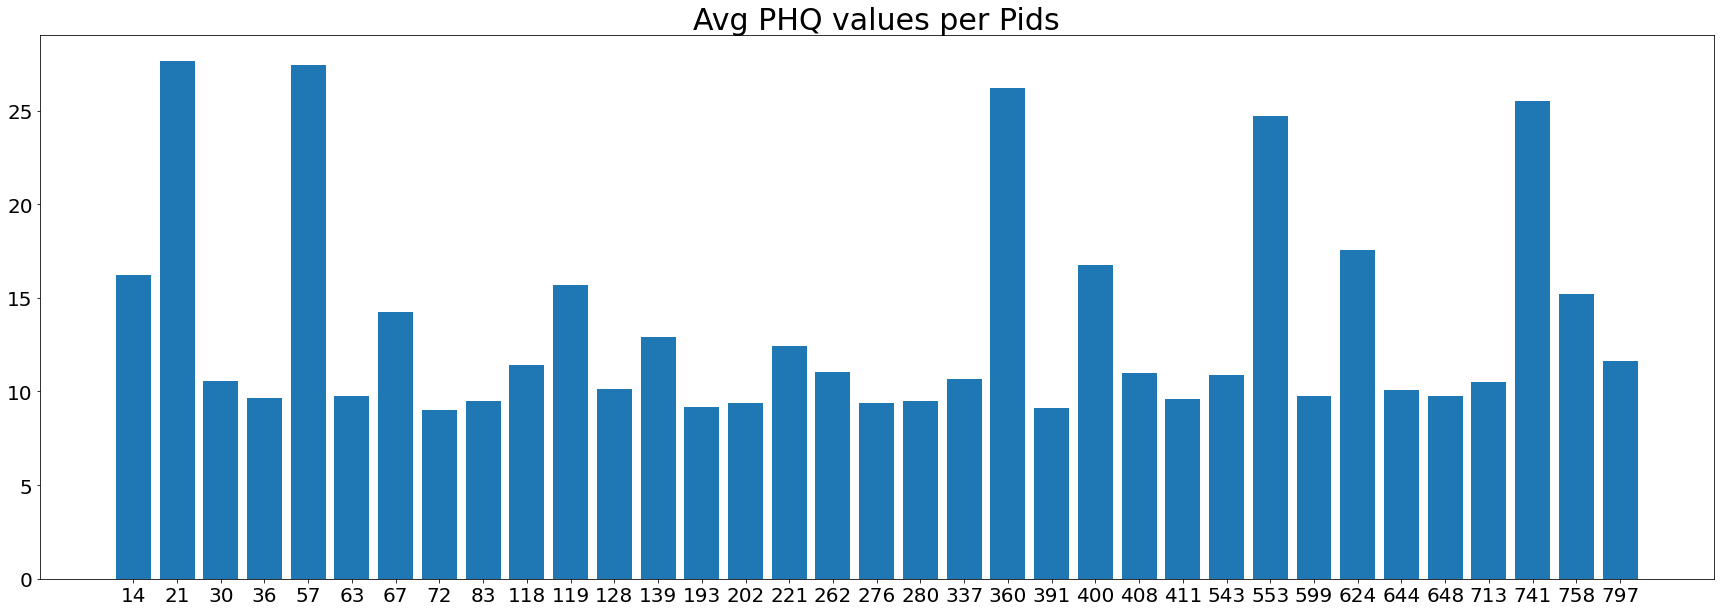

In [41]:
plt.figure(figsize=(30,10))
plt.title('Avg PHQ values per Pids', fontsize=30)
plt.bar(np.array(aos_pids).astype('str'), aos_survey.groupby('pid').mean()['phq'])
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [8]:
# sorting by imbalanced intensity & depressive mood

dunskewed = []
ndunskewed = []
dpids = list()
ndpids = list()
for pid in aos_pids:
    df_pids = aos_ema.loc[pid]
    depressed_count = len(df_pids.loc[df_pids.depressed==1])
    ndepressed_count = len(df_pids.loc[df_pids.depressed==0])
    if depressed_count > ndepressed_count:
      if (ndepressed_count/depressed_count) > 0.1:
        dunskewed.append(pid)
      else: dpids.append(pid)
    else :
      if (depressed_count/ndepressed_count) > 0.1:
        ndunskewed.append(pid)
      else: ndpids.append(pid)

aos_pids_ordered = []
aos_pids_ordered.extend(dunskewed+dpids+ndunskewed+ndpids)   

In [10]:
aos_ema

depressed
pid timestamp                                     
14  2021-09-13 20:26:52.217999872+09:00        1.0
    2021-09-16 12:09:20.220999936+09:00        1.0
    2021-09-16 16:27:39.924999936+09:00        1.0
    2021-09-16 20:11:52.897999872+09:00        1.0
    2021-09-19 12:00:53.323000064+09:00        1.0
...                                            ...
797 2022-02-09 12:00:28.307000064+09:00        0.0
    2022-02-09 16:09:13.928999936+09:00        0.0
    2022-02-12 12:00:42.390000128+09:00        0.0
    2022-02-12 16:22:20.736999936+09:00        0.0
    2022-02-12 20:00:24.059000064+09:00        0.0

[3033 rows x 1 columns]

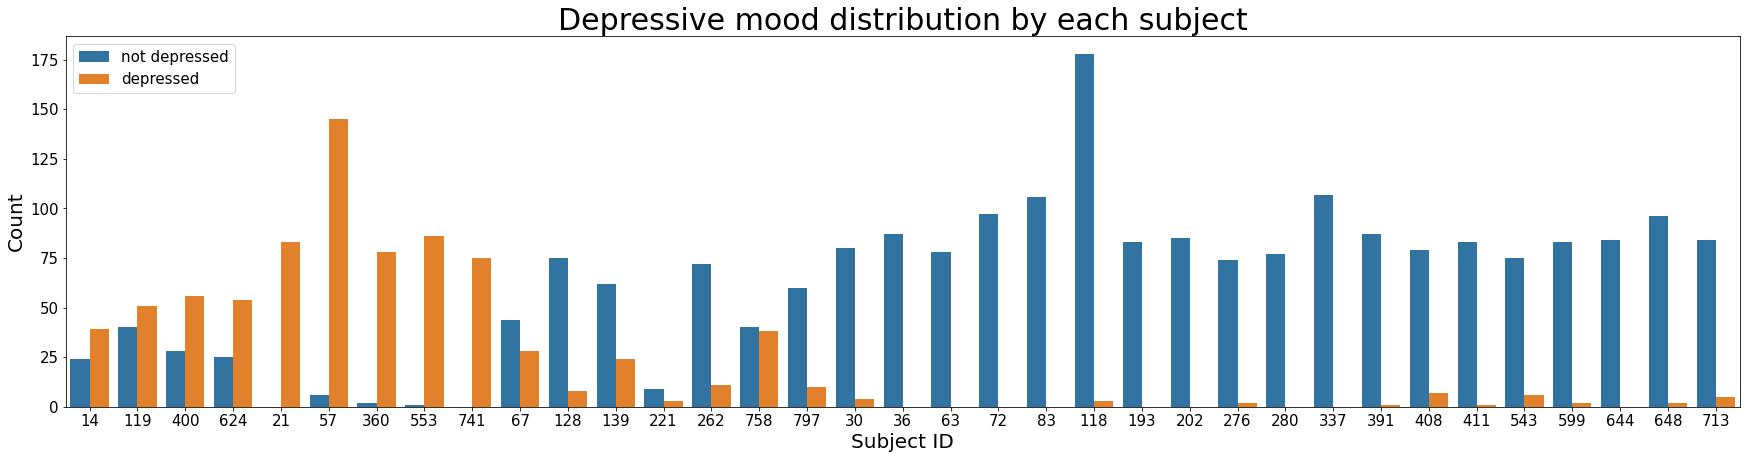

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 15))
ax = fig.add_axes([0,0,1,1])
plt.subplot(2, 1, 1)

plt.tick_params(labelsize = 15)
sns.countplot(x = 'pid', hue ='depressed', data = aos_ema.reset_index(), order=aos_pids_ordered)
plt.title("Depressive mood distribution by each subject", fontsize = 30)
plt.xlabel("Subject ID", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.legend(labels=['not depressed', 'depressed'], fontsize = 15)
plt.show()

## Depressive Mood Cut-off (Wrong approach)

In [30]:
aos_survey_10 = aos_survey.copy()
conditions = [aos_survey_10['phq'] < 12, aos_survey_10['phq'] >= 12]
choices = [0, 1]
aos_survey_10["depressed"] = np.select(conditions, choices, default=np.nan)

In [31]:
aos_survey_10['timestamp'] = pd.to_datetime(aos_survey_10['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
aos_ema_10 = aos_survey_10[['pid', 'timestamp','depressed']]
aos_ema_10.set_index(['pid', 'timestamp'], inplace=True)
aos_ema_10.value_counts()


depressed
0.0          1810
1.0          1223
dtype: int64

In [32]:
aos_ema.value_counts()


depressed
0.0          2211
1.0           822
dtype: int64

In [35]:
# sorting by imbalanced intensity & depressive mood

dunskewed = []
ndunskewed = []
dpids = list()
ndpids = list()
for pid in aos_pids:
    df_pids = aos_ema_10.loc[pid]
    depressed_count = len(df_pids.loc[df_pids.depressed==1])
    ndepressed_count = len(df_pids.loc[df_pids.depressed==0])
    if depressed_count > ndepressed_count:
      if (ndepressed_count/depressed_count) > 0.1:
        dunskewed.append(pid)
      else: dpids.append(pid)
    else :
      if (depressed_count/ndepressed_count) > 0.1:
        ndunskewed.append(pid)
      else: ndpids.append(pid)

aos_pids_ordered = []
aos_pids_ordered.extend(dunskewed+dpids+ndunskewed+ndpids)   

In [39]:
print('balanced pids:', len(dunskewed)+len(ndunskewed))
print('imbalanced pids:', len(dpids)+len(ndpids))

balanced pids: 21
imbalanced pids: 14


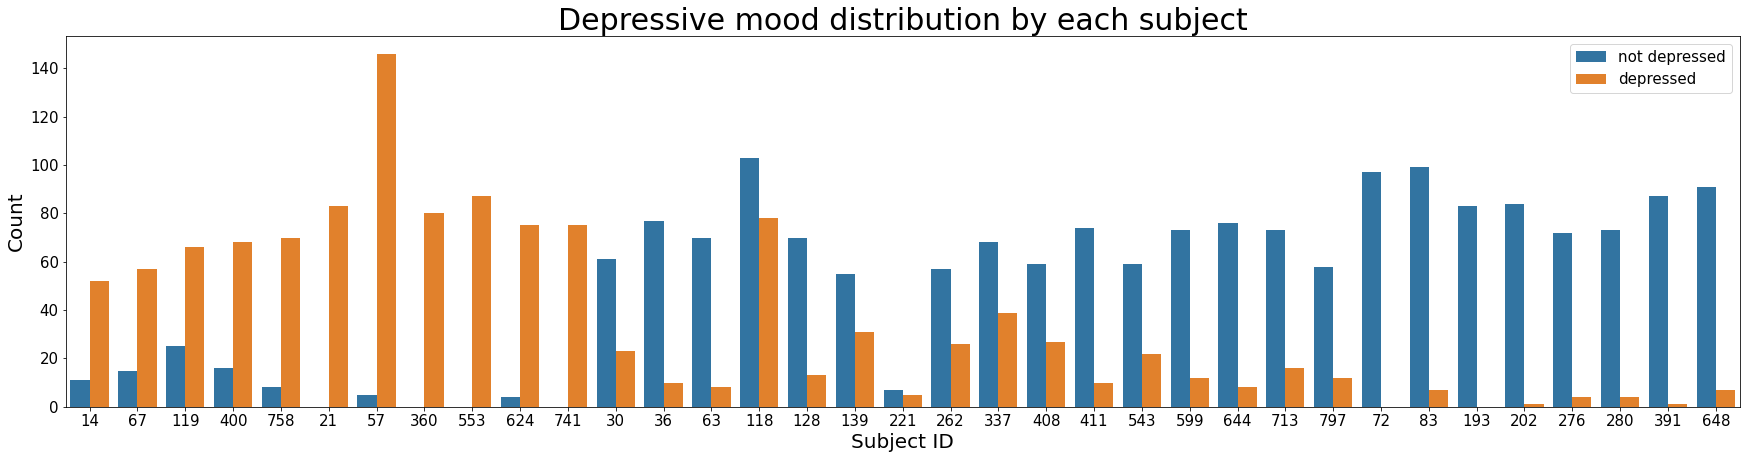

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 15))
ax = fig.add_axes([0,0,1,1])
plt.subplot(2, 1, 1)

plt.tick_params(labelsize = 15)
sns.countplot(x = 'pid', hue ='depressed', data = aos_ema_10.reset_index(), order=aos_pids_ordered)
plt.title("Depressive mood distribution by each subject", fontsize = 30)
plt.xlabel("Subject ID", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.legend(labels=['not depressed', 'depressed'], fontsize = 15)
plt.show()

# Data Collection Protocol (Data Check)
https://docs.google.com/spreadsheets/d/1LgKToYZZPGSVFMCs6Dybyh2gSV5qiQHCtB_x0haHq7Q/edit#gid=0

* 2020년 IITP 2단계 2차 (2021)
* Smartphone os: Andrioid, iOS 
* Age:18-69
* Period: 3 months 일부 6 months
* 각 240명씩 선발하고자 함 (PHQ-9 값에 상관없이, PHQ-9 기준 none: 0~4 mild: 5~9 moderate: 10~14 moderately severe: 15~19 severe: 20~27)
* 사전 검사: BDI-II, K-IDS
* 사후 검사: PHQ-9, BDI-II, K-IDS, 사용성 평가 
* EMA: PHQ-9(1~5 scale), 3일에 하루 3회


In [1]:
import pandas as pd
df_pids = pd.read_excel('IITP_참가자 스크리닝_Data Sharing_220705 (최종).xlsx', sheet_name='STUDY PARTICIPANT(ALL)')
df_pids.columns = df_pids.iloc[1]
df_pids = df_pids[2:]

In [2]:
df_pids.head()

1  ID   이름        전화번호                     이메일 성별                 생년월일  \
2   6  정미리  1021041449      alfl8833@gmail.com  여  1988-12-18 00:00:00   
3  14  이명환  1056529882       sycuel2@gmail.com  남  1998-10-10 00:00:00   
4  20  권채연  1086990543  k.chaeyeon56@gmail.com  여  1996-05-06 00:00:00   
5  21  이유진  1035673222         680h0@naver.com  여  1994-04-12 00:00:00   
6  26  임춘희  1075035206       Mchun72@naver.com  여  1977-10-13 00:00:00   

1     디바이스 스크리닝 점수\n (PHQ-9) SCID 1차 연장  ...                  종료일 종료 예정일  \
2  ANDROID              우울아님  미신청     O  ...  2021-11-19 00:00:00    NaN   
3  ANDROID              중한증상  미신청     -  ...  2021-11-22 00:00:00    NaN   
4  ANDROID              우울아님  미신청     -  ...  2021-11-16 00:00:00    NaN   
5  ANDROID             가벼운증상  미신청     O  ...  2021-11-05 00:00:00    NaN   
6  ANDROID              우울아님  미신청     -  ...  2021-11-25 00:00:00    NaN   

1                                               특이사항 NaN finishid study PHQ-9  \
2                                                NaN NaN              4     3   
3  [김수현/2021-11-26] 분석 시, ID=25와 데이터 통합 필요 (ID=25... NaN              5     4   
4                                                NaN NaN              6     5   
5                                                NaN NaN              7     6   
6                                                NaN NaN              8     7   

1 BDI IDS post 1 \ncomplete post2\ncomplete  
2   3   3              DONE             NaN  
3   4   4              DONE             NaN  
4   5   5              DONE             NaN  
5   6   6              DONE             NaN  
6   7   7              DONE             NaN  

[5 rows x 27 columns]

### Pids check

In [80]:
path_n =  r'C:\Users\shaba\OneDrive - 한국에너지공과대학교\KENTECH\IMC Lab\STDD\campaign5_data'
folders= pd.Series(os.listdir(path_n)[1:65])

In [71]:
import shutil
import os
from os.path import join

new_pids = list()
for folder in folders:
    if os.path.getsize(join(path_n, folder)) != 0:
        new_pids.append(folder)


In [72]:
new_pids

['5-8', '5-868', '5-871', '5-873']

In [73]:
new_pids = list(pd.Series(new_pids).str[2:].astype(int))

In [74]:
new_pids

[8, 868, 871, 873]

In [75]:
pids = list()
for pid in new_pids:  
    if pid in list(df_pids['ID']):
        pids.append(pid)

In [76]:
set(new_pids) - set(pids)

{8, 868, 871}

In [78]:
df_pids.loc[df_pids['ID']==873]['디바이스'].values

array(['IOS'], dtype=object)

In [82]:
# move file dir
'''import shutil
from os.path import join

file = '5'+'-{}'.format(pid)
for pid in pids:
    mobile_os = df_pids.loc[df_pids['ID']==pid]['디바이스'].values
    if mobile_os == 'ANDROID': 
        shutil.move(join(path_n, file), join(path_n, 'Android', file))
    elif mobile_os == 'IOS': 
        shutil.move(join(path_n, file), join(path_n, 'iOS', file))  '''

"import shutil\nfrom os.path import join\n\nfile = '5'+'-{}'.format(pid)\nfor pid in pids:\n    mobile_os = df_pids.loc[df_pids['ID']==pid]['디바이스'].values\n    if mobile_os == 'ANDROID': \n        shutil.move(join(path_n, file), join(path_n, 'Android', file))\n    elif mobile_os == 'IOS': \n        shutil.move(join(path_n, file), join(path_n, 'iOS', file))  "

* 이명환: 14 , 25  
* 박사라: 81  120 
* 김태경: 183  184 
* 장지웅: 244  517 
* 이복순: 553  551 
* 심동민: 633  859 
* 하성영: 873  582 (백업 데이터에 폴더가 1개씩 있음)   
* 김효주: 876  563 (백업 데이터에 폴더가 1개씩 있음) 

In [68]:
pids_dict = dict()
for c in df_pids.columns:
    df = df_pids[c]
    values = set(df.dropna())
    pids_dict[c] = values 

In [69]:
pids_dict.keys()

dict_keys(['ID', '이름', '전화번호', '이메일', '성별', '생년월일', '디바이스', '스크리닝 점수\n (PHQ-9)', 'SCID', '1차 연장', '2차 연장', '3차연장', 'AB집단', '중복ID', '탈락/종료', '시작일\n (*홈페이지 유입일)', '앱 설치일\n (*서버 최초 데이터전송일)', '종료일', '종료 예정일', '특이사항', nan, 'finishid study', 'PHQ-9', 'BDI', 'IDS', 'post 1 \ncomplete', 'post2\ncomplete'])

In [157]:
print(pids_dict['SCID'])
df_pids['SCID'].value_counts()

{'C', 'A', 'B', '기준미달', '미신청'}


미신청     729
A        14
C        12
B        11
기준미달      4
Name: SCID, dtype: int64

In [160]:
print(pids_dict['3차연장'])
df_pids['3차연장'].value_counts()

{'O', '-', '대상자', 'X'}


-      737
O       21
대상자     10
X        2
Name: 3차연장, dtype: int64

In [161]:
print(pids_dict['AB집단'])
df_pids['AB집단'].value_counts()

{'AB_비장애', 'AB_ASD'}


AB_비장애    59
AB_ASD     7
Name: AB집단, dtype: int64

#### Issues (특이사항)

In [213]:
pids_dict['특이사항']

{'(21-11-22) 데이터 전송 이력이 없어 탈락 처리됐으나, \n(21-11-24)연구에 참여하고자 하신다는 연락이 와서 앱 설치 안내 및 미탈락처리로 전환.',
 '(21.12.03)데이터 미전송으로 3회연락했으나 무응답인 관계로 탈락 처리\n(21.12.09)연구종료 도래 시점에서 탈락처리 되어 혹 연구에 지속적으로 참여하실 의사가 있는지 여부 유선 문의 결과 계속 참여하고자 하심/ 연구연장(2)대상자로, 함께 문의 결과 연구연장(2)에도 동의\n2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04. 01)',
 '*2021-08-24의 EMA기록 11월 9일에 싱크완료.',
 '*2021-08-24의 EMA기록 11월 9일에 싱크완료.\n2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04. 01)',
 '- 성별, 생년월일 정보 없음\n- ET앱 로그인으로 인해 2021-11-22부터 2021-12-17까지의 데이터가 서버에 전송되지 않았음. 서버에 데이터가 전송되지 않은 채로 앱 삭제 후 재설치 하여 해당 기간 센서, EMA, 적립금 데이터 없음\n2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04. 01)',
 '- 홈페이지 최초 유입 : 2021. 06.25 / 사후검사 실시 : 2021. 11. 09 / 앱 최초 설치 및 실행일 : 2021. 11. 10\n* 11/10부터 90일간 연구 시작하기로 참가자에게 안내, 동의 받았음. \n* 11/09에 실시한 [사후검사]이력은 관리자 페이지 담당 개발자에게 문의하여 [사전검사]로 전환해두기로 함',
 '1차 서버이슈로 인한 데이터 손실 발생',
 '1차 서버이슈로 인한 데이터 손실 발생\n2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04. 01)',
 '1차 연구연장 이후 2차 연구연장 대상자 (2차 연장기간 시작시, 앱 삭제 후 재설치 예정)\n[김수현/2021-12

In [248]:
df_pids.loc[df_pids['중복ID'].isnull() == False]

1     ID   이름        전화번호                     이메일 성별                 생년월일  \
3     14  이명환  1056529882       sycuel2@gmail.com  남  1998-10-10 00:00:00   
53    81  박사라  1064297024     trillum77@naver.com  여  1984-07-24 00:00:00   
148  183  김태경  1076332803  rlaxorud1020@gmail.com  여  1998-10-20 00:00:00   
206  244  장지웅  1097946503      kyle0914@naver.com  남  2000-09-14 00:00:00   
489  553  이복순  1048101354   sarangcho65@naver.com  여  1965-03-05 00:00:00   
563  633  심동민  1065330779     dmsim1980@gmail.com  남  1980-08-09 00:00:00   
768  873  하성영  1095494225   tjddud_8976@naver.com  여  1992-09-18 00:00:00   
769  876  김효주  1066901025     youngyyss@naver.com  여  1972-08-15 00:00:00   

1       디바이스 스크리닝 점수\n (PHQ-9) SCID 1차 연장  ... 종료 예정일  \
3    ANDROID              중한증상  미신청     -  ...    NaN   
53   ANDROID              우울아님  미신청     O  ...    NaN   
148  ANDROID             가벼운증상  미신청     O  ...    NaN   
206  ANDROID             가벼운증상  미신청     -  ...    NaN   
489  ANDROID             가벼운증상  미신청     -  ...    NaN   
563  ANDROID             가벼운증상  미신청     -  ...    NaN   
768      IOS              심한증상    C     -  ...    NaN   
769  ANDROID              심한증상  미신청     -  ...    NaN   

1                                                 특이사항 NaN finishid study  \
3    [김수현/2021-11-26] 분석 시, ID=25와 데이터 통합 필요 (ID=25... NaN              5   
53   [김수현/2021-11-26] 분석 시, ID=120과 데이터 통합 필요. (ID=... NaN             55   
148             분석 시, ID=184와 데이터 통합 필요 (ID=184와 동일인물) NaN            150   
206             분석 시, ID=517과 데이터 통합 필요 (ID=517과 동일인물) NaN            208   
489             분석 시, ID=551과 데이터 통합 필요 (ID=551과 동일인물) NaN            491   
563             분석 시, ID=859와 데이터 통합 필요 (ID=859와 동일인물) NaN            565   
768  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            770   
769  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            771   

1   PHQ-9  BDI  IDS post 1 \ncomplete post2\ncomplete 데이터 수집 기간  
3       4    4    4              DONE             NaN  101 days  
53     54   54   54              DONE             NaN  151 days  
148   148  148  148              DONE             NaN  150 days  
206   203  203  203              DONE             NaN   93 days  
489   479  479  479              DONE             NaN   92 days  
563   554  554  554              DONE             NaN   90 days  
768   755  762  755              DONE             NaN  187 days  
769   756  763  756              DONE             NaN  249 days  

[8 rows x 28 columns]

In [211]:
# Redundant ID
pids_dict['중복ID']

{551, 563, 582, 'ID=120', 'ID=184', 'ID=25', 'ID=517', 'ID=859'}

In [242]:
red_pid_dict = dict()
red_pid_dict[14] = 25 
red_pid_dict[81] = 120 
red_pid_dict[183] = 184 
red_pid_dict[244] = 517 
red_pid_dict[553] = 551 
red_pid_dict[633] = 859
red_pid_dict[873] = 582 
red_pid_dict[876] = 563  # includeded
# consider when using latest updated version

In [212]:
# Drop out
df_pids['탈락/종료'].value_counts()

연구종료          493
연락 후 탈락       166
자진 탈락         100
연장(2) 중 탈락      5
연장(1) 중 탈락      4
Name: 탈락/종료, dtype: int64

In [312]:
df_pids.loc[df_pids['탈락/종료']=='연락 후 탈락']['데이터 수집 기간'].describe()

count                           166
mean     27 days 22:41:55.662650602
std      27 days 12:06:13.771257984
min                 1 days 00:00:00
25%                10 days 00:00:00
50%                18 days 12:00:00
75%                37 days 00:00:00
max               213 days 00:00:00
Name: 데이터 수집 기간, dtype: object

In [311]:
df_pids.loc[df_pids['탈락/종료']=='자진 탈락']['데이터 수집 기간'].describe()

count                           100
mean               25 days 05:31:12
std      25 days 13:28:00.687597450
min                 0 days 00:00:00
25%                 9 days 00:00:00
50%                16 days 00:00:00
75%                34 days 06:00:00
max               187 days 00:00:00
Name: 데이터 수집 기간, dtype: object

In [307]:
df_pids.loc[(df_pids['탈락/종료']=='연장(1) 중 탈락')&(df_pids['디바이스']=='ANDROID')]['데이터 수집 기간'].describe()

count                             2
mean              111 days 00:00:00
std      12 days 17:28:12.466101318
min               102 days 00:00:00
25%               106 days 12:00:00
50%               111 days 00:00:00
75%               115 days 12:00:00
max               120 days 00:00:00
Name: 데이터 수집 기간, dtype: object

In [310]:
df_pids.loc[(df_pids['탈락/종료']=='연장(2) 중 탈락')&(df_pids['디바이스']=='ANDROID')]['데이터 수집 기간'].describe()

count                             4
mean              133 days 06:00:00
std      35 days 18:03:46.565117237
min                94 days 00:00:00
25%               107 days 12:00:00
50%               136 days 12:00:00
75%               162 days 06:00:00
max               166 days 00:00:00
Name: 데이터 수집 기간, dtype: object

In [295]:
df_pids.loc[(df_pids['탈락/종료']=='연구종료')&(df_pids['디바이스']=='ANDROID')]

1     ID      이름        전화번호                     이메일   성별  \
2      6     정미리  1021041449      alfl8833@gmail.com    여   
3     14     이명환  1056529882       sycuel2@gmail.com    남   
4     20     권채연  1086990543  k.chaeyeon56@gmail.com    여   
5     21     이유진  1035673222         680h0@naver.com    여   
6     26     임춘희  1075035206       Mchun72@naver.com    여   
..   ...     ...         ...                     ...  ...   
760  856  이원준_AB  1056346763   lwj56346763@gmail.com    남   
765  863  안준서_AB  1035227380    junseo7380@gmail.com    남   
766  865  한수민_AB  1051827022       1225cha@gmail.com  NaN   
767  867  최민성_AB  1024728287      chhyjuoo@gmail.com    남   
769  876     김효주  1066901025     youngyyss@naver.com    여   

1                   생년월일     디바이스 스크리닝 점수\n (PHQ-9) SCID 1차 연장  ... 종료 예정일  \
2    1988-12-18 00:00:00  ANDROID              우울아님  미신청     O  ...    NaN   
3    1998-10-10 00:00:00  ANDROID              중한증상  미신청     -  ...    NaN   
4    1996-05-06 00:00:00  ANDROID              우울아님  미신청     -  ...    NaN   
5    1994-04-12 00:00:00  ANDROID             가벼운증상  미신청     O  ...    NaN   
6    1977-10-13 00:00:00  ANDROID              우울아님  미신청     -  ...    NaN   
..                   ...      ...               ...  ...   ...  ...    ...   
760  2008-01-31 00:00:00  ANDROID             가벼운증상  미신청     -  ...    NaN   
765  2007-06-10 00:00:00  ANDROID              우울아님  미신청     -  ...    NaN   
766                  NaN  ANDROID              우울아님  미신청     -  ...    NaN   
767  2008-04-16 00:00:00  ANDROID              우울아님  미신청     -  ...    NaN   
769  1972-08-15 00:00:00  ANDROID              심한증상  미신청     -  ...    NaN   

1                                                 특이사항 NaN finishid study  \
2                                                  NaN NaN              4   
3    [김수현/2021-11-26] 분석 시, ID=25와 데이터 통합 필요 (ID=25... NaN              5   
4                                                  NaN NaN              6   
5                                                  NaN NaN              7   
6                                                  NaN NaN              8   
..                                                 ...  ..            ...   
760  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            762   
765  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            767   
766  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            768   
767  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            769   
769  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            771   

1   PHQ-9  BDI  IDS post 1 \ncomplete post2\ncomplete 데이터 수집 기간  
2       3    3    3              DONE             NaN  150 days  
3       4    4    4              DONE             NaN  101 days  
4       5    5    5              DONE             NaN   91 days  
5       6    6    6              DONE             NaN  151 days  
6       7    7    7              DONE             NaN   99 days  
..    ...  ...  ...               ...             ...       ...  
760   748  755  748               NaN             NaN   90 days  
765   752  759  752              DONE             NaN   90 days  
766   753  760  753               NaN             NaN   94 days  
767   754  761  754               NaN             NaN   90 days  
769   756  763  756              DONE             NaN  249 days  

[324 rows x 28 columns]

In [296]:
df_pids.loc[(df_pids['탈락/종료']=='연구종료')&(df_pids['디바이스']=='IOS')]


1     ID      이름        전화번호                      이메일 성별                 생년월일  \
15    43     한효림  1033618137  hhy2653@sookmyung.ac.kr  여  1997-05-19 00:00:00   
16    44     김보라  1091519047     bora052046@gmail.com  여  2002-05-20 00:00:00   
20    48     손하윤  1056128252      hayun6074@gmail.com  여  2001-03-03 00:00:00   
22    50     오인석  1065141985        hsnoora@naver.com  여  1985-11-22 00:00:00   
23    51     박소린  1044477989      thfls7989@gmail.com  여  2002-06-25 00:00:00   
..   ...     ...         ...                      ... ..                  ...   
752  848  안수현_AB  1084122262    dlwlgus2252@gmail.com  여  2006-03-30 00:00:00   
755  851   이한_AB  1033847579   20040328aron@gmail.com  남  2006-03-28 00:00:00   
757  853  한태완_AB  1086510063      gksxofhkd@gmail.com  여  2006-09-07 00:00:00   
759  855  장민준_AB  1048290021      j48290021@gmail.com  남  2006-06-25 00:00:00   
768  873     하성영  1095494225    tjddud_8976@naver.com  여  1992-09-18 00:00:00   

1   디바이스 스크리닝 점수\n (PHQ-9) SCID 1차 연장  ... 종료 예정일  \
15   IOS              중한증상    B     O  ...    NaN   
16   IOS              우울아님  미신청     -  ...    NaN   
20   IOS              우울아님  미신청     -  ...    NaN   
22   IOS              우울아님  미신청     O  ...    NaN   
23   IOS              우울아님  미신청     -  ...    NaN   
..   ...               ...  ...   ...  ...    ...   
752  IOS              우울아님  미신청     -  ...    NaN   
755  IOS              우울아님  미신청     -  ...    NaN   
757  IOS              우울아님  미신청     -  ...    NaN   
759  IOS              우울아님  미신청     -  ...    NaN   
768  IOS              심한증상    C     -  ...    NaN   

1                                                 특이사항 NaN finishid study  \
15   2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN             17   
16                               1차 서버이슈로 인한 데이터 손실 발생 NaN             18   
20                               1차 서버이슈로 인한 데이터 손실 발생 NaN             22   
22                                                 NaN NaN             24   
23                               1차 서버이슈로 인한 데이터 손실 발생 NaN             25   
..                                                 ...  ..            ...   
752  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            754   
755  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            757   
757  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            759   
759  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            761   
768  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04... NaN            770   

1   PHQ-9  BDI  IDS post 1 \ncomplete post2\ncomplete 데이터 수집 기간  
15     16   16   16              DONE             NaN  241 days  
16     17   17   17              DONE             NaN   90 days  
20     21   21   21              DONE             NaN   92 days  
22     23   23   23              DONE             NaN  158 days  
23     24   24   24              DONE             NaN   92 days  
..    ...  ...  ...               ...             ...       ...  
752   740  747  740               NaN             NaN   90 days  
755   743  750  743               NaN             NaN   90 days  
757   745  752  745               NaN             NaN   90 days  
759   747  754  747               NaN             NaN   90 days  
768   755  762  755              DONE             NaN  187 days  

[169 rows x 28 columns]

In [7]:
df_pids.sort_values(by = '종료일')

1     ID      이름        전화번호                      이메일 성별                 생년월일  \
227  265     심솔지  1029148320    soljishim87@gmail.com  여  1987-11-10 00:00:00   
258  297      유진  1054969179     beeeestj83@gmail.com  여  1999-11-11 00:00:00   
107  138     한송희  1033559927      9736436@hanmail.net  여  1983-11-27 00:00:00   
280  319     송시언  1031180469  heimishun0214@gmail.com  여  2000-02-14 00:00:00   
283  323  HASSAN  1067213293      hsnslhi65@gmail.com  남  1986-07-27 00:00:00   
..   ...     ...         ...                      ... ..                  ...   
593  665     이영주  1040546331        lyj3353@gmail.com  여  1991-12-01 00:00:00   
595  667     박재영  1062372458   tzarbomb1006@gmail.com  남  1985-10-06 00:00:00   
444  493     이유정  1021869316    zlwmxkdla93@gmail.com  여  2002-01-21 00:00:00   
770  878     박지민  1042643465     wuhihi0202@gmail.com  남  2008-01-01 00:00:00   
771  879     정현기  1076042624       hyunkij2@gmail.com  남  2007-10-02 00:00:00   

1       디바이스 스크리닝 점수\n (PHQ-9) SCID 1차 연장  ...                  종료일  \
227  ANDROID              경한증상    A     -  ...  2021-08-31 00:00:00   
258  ANDROID              우울아님  미신청     -  ...  2021-09-01 00:00:00   
107  ANDROID              우울아님  미신청     X  ...  2021-09-01 00:00:00   
280      IOS              우울아님  미신청     -  ...  2021-09-02 00:00:00   
283  ANDROID              우울아님  미신청     -  ...  2021-09-03 00:00:00   
..       ...               ...  ...   ...  ...                  ...   
593      IOS              우울아님  미신청     -  ...  2022-06-22 00:00:00   
595  ANDROID              중한증상  미신청     -  ...  2022-06-23 00:00:00   
444      IOS             가벼운증상  미신청     -  ...  2022-06-27 00:00:00   
770  ANDROID              우울아님  미신청     -  ...                  NaN   
771  ANDROID              우울아님  미신청     -  ...                  NaN   

1                 종료 예정일                                               특이사항  \
227                  NaN    필수 업데이트 설치하였으나, 앱 권한 설정 및 데이터 전송은 하지 않은 채 참여 중단   
258                  NaN                                                NaN   
107                  NaN  필수업데이트 시기 이전 연구시작 초반부터 서버와 연결이 끊긴채로 참여한 참가자. 추...   
280                  NaN                                                NaN   
283                  NaN                                                NaN   
..                   ...                                                ...   
593                  NaN  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04...   
595                  NaN  2차 서버이슈에 의한 데이터 손실 발생 (2022. 02. 19 ~ 2022. 04...   
444                  NaN  [김수현/2021-12-24] CAPTURED_PHOTOS전송을 위한 필수 업데이트...   
770  2022-07-22 00:00:00                                                NaN   
771  2022-08-04 00:00:00                                                NaN   

1   NaN finishid study PHQ-9  BDI  IDS post 1 \ncomplete post2\ncomplete  
227 NaN            229   225  225  225               NaN             NaN  
258 NaN            260   255  255  255               NaN             NaN  
107 NaN            109   108  108  108              DONE             NaN  
280 NaN            282   277  277  277               NaN             NaN  
283 NaN            285   280  280  280               NaN             NaN  
..   ..            ...   ...  ...  ...               ...             ...  
593 NaN            595   584  584  584              DONE             NaN  
595 NaN            597   586  586  586              DONE             NaN  
444 NaN            446   437  437  437              DONE             NaN  
770 NaN            772   757  764  757               NaN             NaN  
771 NaN            773   758  765  758               NaN             NaN  

[770 rows x 27 columns]

In [8]:
# 7/05 기준 종료 안된 참여자들: 2명 (->연구종료)
df_pids[-2:]['시작일\n (*홈페이지 유입일)']

770    2022-04-23 00:00:00
771    2022-04-22 00:00:00
Name: 시작일\n (*홈페이지 유입일), dtype: object

In [249]:
# Server issue, birthday error, permission setting incomplete
print('-'*5, '서버이슈로 인한 데이터 손실 발생', '-'*5)
print('1차 서버이슈:', len(df_pids['특이사항'][df_pids['특이사항'].str.contains('1차 서버이슈') == True]))
print('2차 서버이슈:', len(df_pids['특이사항'][df_pids['특이사항'].str.contains('2차 서버이슈') == True]))
print('-'*5, '생년월일 오류', '-'*5)
print('생년월일 정보 없음:', len(df_pids['특이사항'][df_pids['특이사항'].str.contains('생년월일') == True]))
print('생년월일 오기입:', len(df_pids['특이사항'][df_pids['특이사항'].str.contains('출생년도') == True]))
print('-'*5, '권한설정 오류', '-'*5)
print('권한설정 미완료:', len(df_pids['특이사항'][df_pids['특이사항'].str.contains('권한설정') == True]))

----- 서버이슈로 인한 데이터 손실 발생 -----
1차 서버이슈: 55
2차 서버이슈: 122
----- 생년월일 오류 -----
생년월일 정보 없음: 4
생년월일 오기입: 4
----- 권한설정 오류 -----
권한설정 미완료: 6


In [283]:
nauto_pids = list(df_pids[df_pids['특이사항'].str.contains('권한설정') == True]['ID'])
nbirth_pids = [351, 469, 843, 845, 608, 798, 810, 833]
ser1_pids = list(df_pids[df_pids['특이사항'].str.contains('1차 서버이슈') == True]['ID'])
ser2_pids = list(df_pids[df_pids['특이사항'].str.contains('2차 서버이슈') == True]['ID'])
ser12_pids = list(set(ser1_pids)&set(ser2_pids))


In [285]:
ser12_pids

[259, 142, 78, 57, 90, 94]

In [309]:
df_pids[df_pids['특이사항'].str.contains('1차 서버이슈') == True]['데이터 수집 기간'].describe()

count                             55
mean     102 days 06:32:43.636363636
std       30 days 11:31:45.267267805
min                 68 days 00:00:00
25%                 90 days 00:00:00
50%                 90 days 00:00:00
75%                 92 days 00:00:00
max                180 days 00:00:00
Name: 데이터 수집 기간, dtype: object

In [308]:
df_pids[df_pids['특이사항'].str.contains('2차 서버이슈') == True]['데이터 수집 기간'].describe()

count                            122
mean     147 days 23:48:11.803278688
std       68 days 21:24:49.345314581
min                 17 days 00:00:00
25%                 90 days 00:00:00
50%                 94 days 00:00:00
75%                192 days 00:00:00
max                281 days 00:00:00
Name: 데이터 수집 기간, dtype: object

#### Data Collection Period Extension (1차, 2차, 3차 연장)

In [108]:
df_pids['데이터 수집 기간'] = pd.to_datetime(df_pids['종료일']) - pd.to_datetime(df_pids['시작일\n (*홈페이지 유입일)'])

In [251]:
pd.to_datetime(df_pids['종료일']).max()

Timestamp('2022-06-27 00:00:00')

In [144]:
print(df_pids['데이터 수집 기간'].min())
print(df_pids['데이터 수집 기간'].max())

0 days 00:00:00
281 days 00:00:00


In [147]:
print('-'*20, '1차 연장', '-'*20)
print('min period:', df_pids.loc[df_pids['1차 연장']=='O']['데이터 수집 기간'].min())
print('max period:', df_pids.loc[df_pids['1차 연장']=='O']['데이터 수집 기간'].max())
print('-'*20, '2차 연장', '-'*20)
print('min period:', df_pids.loc[df_pids['2차 연장']=='O']['데이터 수집 기간'].min())
print('max period:', df_pids.loc[df_pids['2차 연장']=='O']['데이터 수집 기간'].max())
print('-'*20, '3차 연장', '-'*20)
print('min period:', df_pids.loc[df_pids['3차연장']=='O']['데이터 수집 기간'].min())
print('max period:', df_pids.loc[df_pids['3차연장']=='O']['데이터 수집 기간'].max())


-------------------- 1차 연장 --------------------
min period: 102 days 00:00:00
max period: 252 days 00:00:00
-------------------- 2차 연장 --------------------
min period: 94 days 00:00:00
max period: 281 days 00:00:00
-------------------- 3차 연장 --------------------
min period: 213 days 00:00:00
max period: 281 days 00:00:00


In [142]:
df_pids.loc[df_pids['1차 연장']=='O'][['시작일\n (*홈페이지 유입일)', '종료일']].sort_values(by = '시작일\n (*홈페이지 유입일)').head()

1      시작일\n (*홈페이지 유입일)                  종료일
259  2021-05-31 00:00:00  2021-11-20 00:00:00
370  2021-05-31 00:00:00  2021-10-29 00:00:00
5    2021-06-07 00:00:00  2021-11-05 00:00:00
148  2021-06-08 00:00:00  2021-11-05 00:00:00
39   2021-06-08 00:00:00  2021-11-05 00:00:00

In [148]:
df_pids.loc[df_pids['2차 연장']=='O'][['시작일\n (*홈페이지 유입일)', '종료일']].sort_values(by = '시작일\n (*홈페이지 유입일)').head()

1      시작일\n (*홈페이지 유입일)                  종료일
59   2021-06-16 00:00:00  2022-02-16 00:00:00
33   2021-06-18 00:00:00  2022-02-16 00:00:00
195  2021-06-19 00:00:00  2022-02-26 00:00:00
15   2021-07-06 00:00:00  2022-03-04 00:00:00
84   2021-07-06 00:00:00  2022-03-03 00:00:00

In [149]:
df_pids.loc[df_pids['3차연장']=='O'][['시작일\n (*홈페이지 유입일)', '종료일']].sort_values(by = '시작일\n (*홈페이지 유입일)').head()

1      시작일\n (*홈페이지 유입일)                  종료일
407  2021-09-15 00:00:00  2022-06-14 00:00:00
410  2021-09-15 00:00:00  2022-06-15 00:00:00
444  2021-09-19 00:00:00  2022-06-27 00:00:00
450  2021-09-24 00:00:00  2022-06-14 00:00:00
475  2021-10-04 00:00:00  2022-06-18 00:00:00

# Group Analysis
### Participants with two pids

1. Matched pids
* 이명환: 14  25  
* 박사라: 81  120 
* 김태경: 183  184 
* 장지웅: 244  517 
* 이복순: 553  551 
* 심동민: 633  859

2. Unmatched pids
* 하성영: 873  582 (iOS)   
* 김효주: 876  563 (Android) 

## Grouping Participants

In [1]:
import pandas as pd
df_pids = pd.read_excel('IITP_참가자 스크리닝_Data Sharing_220705 (최종).xlsx', sheet_name='STUDY PARTICIPANT(ALL)')
df_pids.columns = df_pids.iloc[1]
df_pids = df_pids[2:]

# match the redundant pids
df_pids['ID'].iloc[766] = 582 # iOS
df_pids['ID'].iloc[767] = 563 # Android

c:\Users\shaba\anaconda3\envs\stdd\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [2]:
df_group = df_pids.loc[:, ['ID', '이름', '성별', '생년월일', '스크리닝 점수\n (PHQ-9)']]
df_group.columns = ['ID', 'NAME', 'GENDER', 'BIRTHDAY', 'SCREENING']

df_group['SCREENING'] = df_group['SCREENING'].apply(lambda x : 'normal' if x =='우울아님' else x)
df_group['SCREENING'] = df_group['SCREENING'].apply(lambda x : 'mild' if x =='가벼운증상' else x) 
df_group['SCREENING'] = df_group['SCREENING'].apply(lambda x : 'moderate' if x =='경한증상' else x) 
df_group['SCREENING'] = df_group['SCREENING'].apply(lambda x : 'severe' if x =='중한증상' else x) 
df_group['SCREENING'] = df_group['SCREENING'].apply(lambda x : 'significantly severe' if x =='심한증상' else x) 

# intergrate into one group
df_group_3 = df_group.copy()
df_group_3['SCREENING'] = df_group_3['SCREENING'].apply(lambda x : 'depressed' if x =='moderate' else x) 
df_group_3['SCREENING'] = df_group_3['SCREENING'].apply(lambda x : 'depressed' if x =='severe' else x) 
df_group_3['SCREENING'] = df_group_3['SCREENING'].apply(lambda x : 'depressed' if x =='significantly severe' else x) 

In [ ]:
# read Android gps data for Android pids
aos_gps = pd.read_csv('aos_features/aos_LOCATION_4HR.csv', index_col=0)
aos_pids = list(set(aos_gps.index))
aos_pids.sort()

# read iOS gps data for iOS pids
ios_gps = pd.read_csv('ios_features/ios_LOCATION_4HR.csv', index_col=0)
ios_pids = list(set(ios_gps.index))
ios_pids.sort()

In [16]:
import pickle

# load data
with open('pids.pickle', 'rb') as fr:
    pids_dict = pickle.load(fr)

In [19]:
aos_pids = pids_dict['aos_pids']
ios_pids = pids_dict['ios_pids']

In [20]:
# define sensors
aos_sensors = ['APPUSAGE', 'CALL', 'GRAVITY', 'KEYSTROKE', 'LIGHT', 'LOCATION', 'NOTIFICATION', 'SCREEN_STATE', 'SIGNIFICANT_MOTION', 'SOUND', 'STEP', 'TYPING']
ios_sensors = ['CALL', 'GRAVITY', 'LOCATION', 'SCREEN_STATE', 'SIGNIFICANT_MOTION', 'SOUND', 'STEP']


aos_survey = pd.read_csv('aos_features/aos_survey.csv', index_col=0)
aos_survey['timestamp'] = pd.to_datetime(aos_survey['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
aos_ema = aos_survey[['pid', 'timestamp', 'phq', 'depressed']]
aos_ema.set_index(['pid', 'timestamp'], inplace=True)
aos_ema = aos_ema.loc[aos_pids]


ios_survey = pd.read_csv('ios_features/ios_survey.csv', index_col=0)
ios_survey['timestamp'] = pd.to_datetime(ios_survey['timestamp'], unit='ms', utc=True).dt.tz_convert('Asia/Seoul')
ios_ema = ios_survey[['pid', 'timestamp', 'phq', 'depressed']]
ios_ema.set_index(['pid', 'timestamp'], inplace=True)
ios_ema = ios_ema.loc[ios_pids]

In [21]:
# define path for loading data
path = r'C:\Users\shaba\OneDrive - 한국에너지공과대학교\KENTECH\IMC Lab\STDD\Code_stdd'
aos_path = join(path, 'aos_features')
ios_path = join(path, 'ios_features')

# Android
df_list = list()
aos_dataset = pd.DataFrame()
interval = 4
for sensor in aos_sensors:
    aos_file = join(aos_path,'aos_{}_{}HR.csv'.format(sensor, interval))
    df = pd.read_csv(aos_file, index_col = 0)
    df = df.loc[aos_pids]
    df.reset_index(inplace=True)
  #  df['pid'] = df['pid'].apply(lambda x: 873 if x == 582 else x)
    df_list.append(df)

aos_dataset = pd.concat(df_list, axis=1)
aos_dataset.drop(['pid','timestamp'], axis=1, inplace=True)
aos_dataset.index = aos_ema.index
aos_dataset['phq'] = aos_ema['phq']
aos_dataset.interpolate(method='linear', inplace=True, limit_direction="both") # sound data still has missing values: check this out

# iOS
df_list = list()
ios_dataset = pd.DataFrame()
interval = 4
for sensor in ios_sensors:
    ios_file = join(ios_path,'ios_{}_{}HR.csv'.format(sensor, interval))
    df = pd.read_csv(ios_file, index_col = 0)
    df = df.loc[ios_pids]
    df.reset_index(inplace=True)
  #  df['pid'] = df['pid'].apply(lambda x: 873 if x == 582 else x)
    df_list.append(df)

ios_dataset = pd.concat(df_list, axis=1)
ios_dataset.drop(['pid','timestamp'], axis=1, inplace=True)
ios_dataset.index = ios_ema.index
ios_dataset['phq'] = ios_ema['phq']

In [22]:
ios_dataset.isnull().sum().sort_values(ascending=False)[:10]


CALL#4HR#count_ratio_in2out            0
SCREEN_STATE#4HR#normalized_entropy    0
LOCATION#4HR#max_distance              0
LOCATION#4HR#max_dist_home             0
LOCATION#4HR#radius_gyration           0
LOCATION#4HR#std_displacement          0
LOCATION#4HR#num_places                0
LOCATION#4HR#num_significant_places    0
SCREEN_STATE#4HR#onCount               0
SCREEN_STATE#4HR#offCount              0
dtype: int64

In [23]:
aos_dataset.isnull().sum().sort_values(ascending=False)[:10]


appusage#4HR#app_count                 0
LOCATION#4HR#total_distance            0
NOTIFICATIONS#4HR#ARRIVED_freq         0
LOCATION#4HR#num_significant_places    0
LOCATION#4HR#num_places                0
LOCATION#4HR#std_displacement          0
LOCATION#4HR#radius_gyration           0
LOCATION#4HR#max_dist_home             0
LOCATION#4HR#max_distance              0
LIGHT#4HR#Brightness_Log#skewness      0
dtype: int64

In [24]:
# Distinguish Android, iOS users
df_group_3.index = df_group_3['ID']
ios_group = df_group_3.loc[ios_pids]
aos_group = df_group_3.loc[aos_pids]

# Grouping Android users
aos_normal = aos_group.loc[aos_group['SCREENING']=='normal']
aos_mild = aos_group.loc[aos_group['SCREENING']=='mild']
aos_severe = aos_group.loc[aos_group['SCREENING']=='depressed']
aos_normal_pids = list(aos_normal['ID'])
aos_mild_pids = list(aos_mild['ID'])
aos_severe_pids = list(aos_severe['ID'])
aos_norm_df = aos_dataset.loc[aos_normal_pids]
aos_mild_df = aos_dataset.loc[aos_mild_pids]
aos_seve_df = aos_dataset.loc[aos_severe_pids]

# Grouping iOS users
ios_normal = ios_group.loc[ios_group['SCREENING']=='normal']
ios_mild = ios_group.loc[ios_group['SCREENING']=='mild']
ios_severe = ios_group.loc[ios_group['SCREENING']=='depressed']
ios_normal_pids = list(ios_normal['ID'])
ios_mild_pids = list(ios_mild['ID'])
ios_severe_pids = list(ios_severe['ID'])
ios_norm_df = ios_dataset.loc[ios_normal_pids]
ios_mild_df = ios_dataset.loc[ios_mild_pids]
ios_seve_df = ios_dataset.loc[ios_severe_pids]

## Statistical Analysis

### Correlation Matrix

In [25]:
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau

In [326]:
aos_group  = aos_dataset.copy()

# all aos subjects
aos_group_corr = list()
aos_group_pv = list()

for c1 in aos_group.columns:
    corr_list = list()
    pv_list = list()
    for c2 in aos_group.columns:
        f1= aos_group[c1]
        f2= aos_group[c2]
        corr, p_value = pearsonr(f1, f2)
        corr_list.append(corr)
        pv_list.append(p_value)

    aos_group_corr.append(corr_list)
    aos_group_pv.append(pv_list)

aos_group_corr = pd.DataFrame(aos_group_corr)
aos_group_pv = pd.DataFrame(aos_group_pv)

aos_group_corr.columns = aos_group.columns
aos_group_corr.index = aos_group.columns 
aos_group_pv.columns = aos_group.columns
aos_group_pv.index = aos_group.columns 

# normal subjects
aos_norm_df_corr = list()
aos_norm_df_pv = list()

for c1 in aos_norm_df.columns:
    corr_list = list()
    pv_list = list()
    for c2 in aos_norm_df.columns:
        f1= aos_norm_df[c1]
        f2= aos_norm_df[c2]
        corr, p_value = pearsonr(f1, f2)
        corr_list.append(corr)
        pv_list.append(p_value)

    aos_norm_df_corr.append(corr_list)
    aos_norm_df_pv.append(pv_list)

aos_norm_df_corr = pd.DataFrame(aos_norm_df_corr)
aos_norm_df_pv = pd.DataFrame(aos_norm_df_pv)

aos_norm_df_corr.columns = aos_norm_df.columns
aos_norm_df_corr.index = aos_norm_df.columns 
aos_norm_df_pv.columns = aos_norm_df.columns
aos_norm_df_pv.index = aos_norm_df.columns 

# mild subjects
aos_mild_df_corr = list()
aos_mild_df_pv = list()

for c1 in aos_mild_df.columns:
    corr_list = list()
    pv_list = list()
    for c2 in aos_mild_df.columns:
        f1= aos_mild_df[c1]
        f2= aos_mild_df[c2]
        corr, p_value = pearsonr(f1, f2)
        corr_list.append(corr)
        pv_list.append(p_value)

    aos_mild_df_corr.append(corr_list)
    aos_mild_df_pv.append(pv_list)

aos_mild_df_corr = pd.DataFrame(aos_mild_df_corr)
aos_mild_df_pv = pd.DataFrame(aos_mild_df_pv)

aos_mild_df_corr.columns = aos_mild_df.columns
aos_mild_df_corr.index = aos_mild_df.columns 
aos_mild_df_pv.columns = aos_mild_df.columns
aos_mild_df_pv.index = aos_mild_df.columns 

# severe subjects
aos_seve_df_corr = list()
aos_seve_df_pv = list()

for c1 in aos_seve_df.columns:
    corr_list = list()
    pv_list = list()
    for c2 in aos_seve_df.columns:
        f1= aos_seve_df[c1]
        f2= aos_seve_df[c2]
        corr, p_value = pearsonr(f1, f2)
        corr_list.append(corr)
        pv_list.append(p_value)

    aos_seve_df_corr.append(corr_list)
    aos_seve_df_pv.append(pv_list)

aos_seve_df_corr = pd.DataFrame(aos_seve_df_corr)
aos_seve_df_pv = pd.DataFrame(aos_seve_df_pv)

aos_seve_df_corr.columns = aos_seve_df.columns
aos_seve_df_corr.index = aos_seve_df.columns 
aos_seve_df_pv.columns = aos_seve_df.columns
aos_seve_df_pv.index = aos_seve_df.columns 

# extract statistically significant features (p<0.05)
aos_all_sig = aos_group_pv['phq'].loc[aos_group_pv['phq']<0.05].index
aos_norm_sig = aos_norm_df_pv['phq'].loc[aos_norm_df_pv['phq']<0.05].index
aos_mild_sig = aos_mild_df_pv['phq'].loc[aos_mild_df_pv['phq']<0.05].index
aos_seve_sig = aos_seve_df_pv['phq'].loc[aos_seve_df_pv['phq']<0.05].index

In [325]:
ios_group  = ios_dataset.copy()

# all ios subjects
ios_group_corr = list()
ios_group_pv = list()

for c1 in ios_group.columns:
    corr_list = list()
    pv_list = list()
    for c2 in ios_group.columns:
        f1= ios_group[c1]
        f2= ios_group[c2]
        corr, p_value = pearsonr(f1, f2)
        corr_list.append(corr)
        pv_list.append(p_value)

    ios_group_corr.append(corr_list)
    ios_group_pv.append(pv_list)

ios_group_corr = pd.DataFrame(ios_group_corr)
ios_group_pv = pd.DataFrame(ios_group_pv)

ios_group_corr.columns = ios_group.columns
ios_group_corr.index = ios_group.columns 
ios_group_pv.columns = ios_group.columns
ios_group_pv.index = ios_group.columns 

# normal subjects
ios_norm_df_corr = list()
ios_norm_df_pv = list()

for c1 in ios_norm_df.columns:
    corr_list = list()
    pv_list = list()
    for c2 in ios_norm_df.columns:
        f1= ios_norm_df[c1]
        f2= ios_norm_df[c2]
        corr, p_value = pearsonr(f1, f2)
        corr_list.append(corr)
        pv_list.append(p_value)

    ios_norm_df_corr.append(corr_list)
    ios_norm_df_pv.append(pv_list)

ios_norm_df_corr = pd.DataFrame(ios_norm_df_corr)
ios_norm_df_pv = pd.DataFrame(ios_norm_df_pv)

ios_norm_df_corr.columns = ios_norm_df.columns
ios_norm_df_corr.index = ios_norm_df.columns 
ios_norm_df_pv.columns = ios_norm_df.columns
ios_norm_df_pv.index = ios_norm_df.columns 

# mild subjects
ios_mild_df_corr = list()
ios_mild_df_pv = list()

for c1 in ios_mild_df.columns:
    corr_list = list()
    pv_list = list()
    for c2 in ios_mild_df.columns:
        f1= ios_mild_df[c1]
        f2= ios_mild_df[c2]
        corr, p_value = pearsonr(f1, f2)
        corr_list.append(corr)
        pv_list.append(p_value)

    ios_mild_df_corr.append(corr_list)
    ios_mild_df_pv.append(pv_list)

ios_mild_df_corr = pd.DataFrame(ios_mild_df_corr)
ios_mild_df_pv = pd.DataFrame(ios_mild_df_pv)

ios_mild_df_corr.columns = ios_mild_df.columns
ios_mild_df_corr.index = ios_mild_df.columns 
ios_mild_df_pv.columns = ios_mild_df.columns
ios_mild_df_pv.index = ios_mild_df.columns 

# severe subjects
ios_seve_df_corr = list()
ios_seve_df_pv = list()

for c1 in ios_seve_df.columns:
    corr_list = list()
    pv_list = list()
    for c2 in ios_seve_df.columns:
        f1= ios_seve_df[c1]
        f2= ios_seve_df[c2]
        corr, p_value = pearsonr(f1, f2)
        corr_list.append(corr)
        pv_list.append(p_value)

    ios_seve_df_corr.append(corr_list)
    ios_seve_df_pv.append(pv_list)

ios_seve_df_corr = pd.DataFrame(ios_seve_df_corr)
ios_seve_df_pv = pd.DataFrame(ios_seve_df_pv)

ios_seve_df_corr.columns = ios_seve_df.columns
ios_seve_df_corr.index = ios_seve_df.columns 
ios_seve_df_pv.columns = ios_seve_df.columns
ios_seve_df_pv.index = ios_seve_df.columns 

# extract statistically significant features (p<0.05)
ios_all_sig = ios_group_pv['phq'].loc[ios_group_pv['phq']<0.05].index
ios_norm_sig = ios_norm_df_pv['phq'].loc[ios_norm_df_pv['phq']<0.05].index
ios_mild_sig = ios_mild_df_pv['phq'].loc[ios_mild_df_pv['phq']<0.05].index
ios_seve_sig = ios_seve_df_pv['phq'].loc[ios_seve_df_pv['phq']<0.05].index

In [328]:
aos_pearson = pd.concat( [aos_group_corr['phq'], aos_group_pv['phq'], 
                 aos_norm_df_corr['phq'], aos_norm_df_pv['phq'], 
                 aos_mild_df_corr['phq'], aos_mild_df_pv['phq'], 
                 aos_seve_df_corr['phq'], aos_seve_df_pv['phq']], axis=1 )

aos_pearson.columns = ['all_pc', 'all_pv', 'norm_pc', 'norm_pv', 'mild_pc', 'mild_pv', 'seve_pc', 'seve_pv']

ios_pearson = pd.concat( [ios_group_corr['phq'], ios_group_pv['phq'], 
                 ios_norm_df_corr['phq'], ios_norm_df_pv['phq'], 
                 ios_mild_df_corr['phq'], ios_mild_df_pv['phq'], 
                 ios_seve_df_corr['phq'], ios_seve_df_pv['phq']], axis=1 )

ios_pearson.columns = ['all_pc', 'all_pv', 'norm_pc', 'norm_pv', 'mild_pc', 'mild_pv', 'seve_pc', 'seve_pv']

In [322]:
aos_spearman = pd.concat( [aos_group_corr['phq'], aos_group_pv['phq'], 
                 aos_norm_df_corr['phq'], aos_norm_df_pv['phq'], 
                 aos_mild_df_corr['phq'], aos_mild_df_pv['phq'], 
                 aos_seve_df_corr['phq'], aos_seve_df_pv['phq']], axis=1 )

aos_spearman.columns = ['all_sc', 'all_pv', 'norm_sc', 'norm_pv', 'mild_sc', 'mild_pv', 'seve_sc', 'seve_pv']

ios_spearman = pd.concat( [ios_group_corr['phq'], ios_group_pv['phq'], 
                 ios_norm_df_corr['phq'], ios_norm_df_pv['phq'], 
                 ios_mild_df_corr['phq'], ios_mild_df_pv['phq'], 
                 ios_seve_df_corr['phq'], ios_seve_df_pv['phq']], axis=1 )

ios_spearman.columns = ['all_sc', 'all_pv', 'norm_sc', 'norm_pv', 'mild_sc', 'mild_pv', 'seve_sc', 'seve_pv']

In [323]:
dict_corr = {}
dict_corr['Android_Pearson'] = aos_pearson
dict_corr['iOS_Pearson'] = ios_pearson 
dict_corr['Android_Spearman'] = aos_spearman
dict_corr['iOS_Spearman'] = ios_spearman 

In [337]:
import pickle
 # save data
with open('correlation_result.pickle', 'wb') as fw:
    pickle.dump(dict_corr, fw)

In [227]:
aos_all_idx = aos_all_sig & set(aos_group_corr['phq'].loc[abs(aos_group_corr['phq'])>0.1].index)
aos_norm_idx = aos_norm_sig & set(aos_norm_df_corr['phq'].loc[abs(aos_norm_df_corr['phq'])>0.1].index)
aos_mild_idx = aos_mild_sig & set(aos_mild_df_corr['phq'].loc[abs(aos_mild_df_corr['phq'])>0.1].index)
aos_seve_idx = aos_seve_sig & set(aos_seve_df_corr['phq'].loc[abs(aos_seve_df_corr['phq'])>0.1].index)

c:\Users\shaba\anaconda3\envs\stdd\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  """Entry point for launching an IPython kernel.
c:\Users\shaba\anaconda3\envs\stdd\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  
c:\Users\shaba\anaconda3\envs\stdd\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\shaba\anaconda3\envs\stdd\lib\site-packages\ipykernel_launcher.py:4: F

#### Android: All

In [ ]:
sns.set(rc={'figure.figsize':(30,15)})
print(len(aos_all_sig))
sns.heatmap(aos_group_corr.loc[aos_all_sig][aos_all_sig], annot=True, annot_kws={'size': 8}, xticklabels=True, yticklabels=True, cmap="BuGn")

1


<AxesSubplot:>

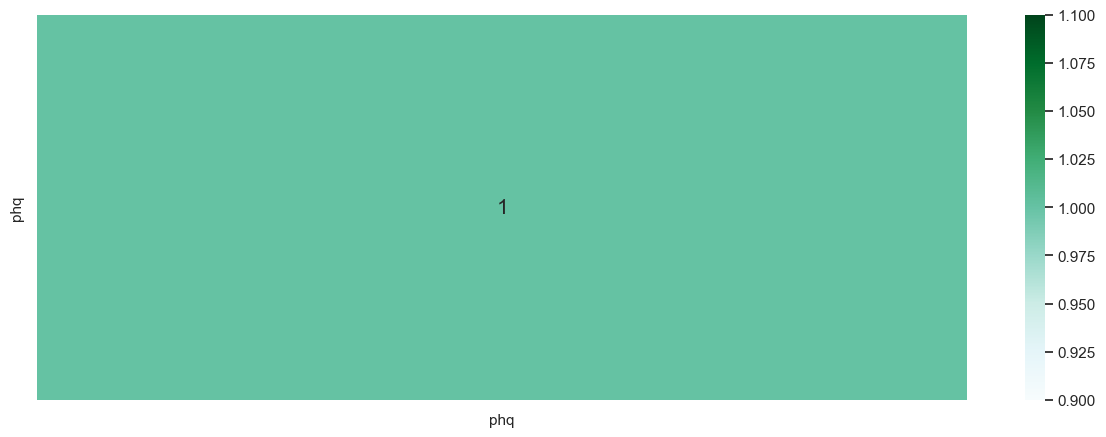

In [228]:
sns.set(rc={'figure.figsize':(15,5)})
print(len(aos_all_idx))
sns.heatmap(aos_group_corr.loc[aos_all_idx][aos_all_idx], annot=True, annot_kws={'size': 15}, xticklabels=True, yticklabels=True, cmap="BuGn")

In [229]:
aos_all_phq = pd.DataFrame(aos_group_corr['phq'])
aos_all_phq.sort_values(by = 'phq', inplace=True)

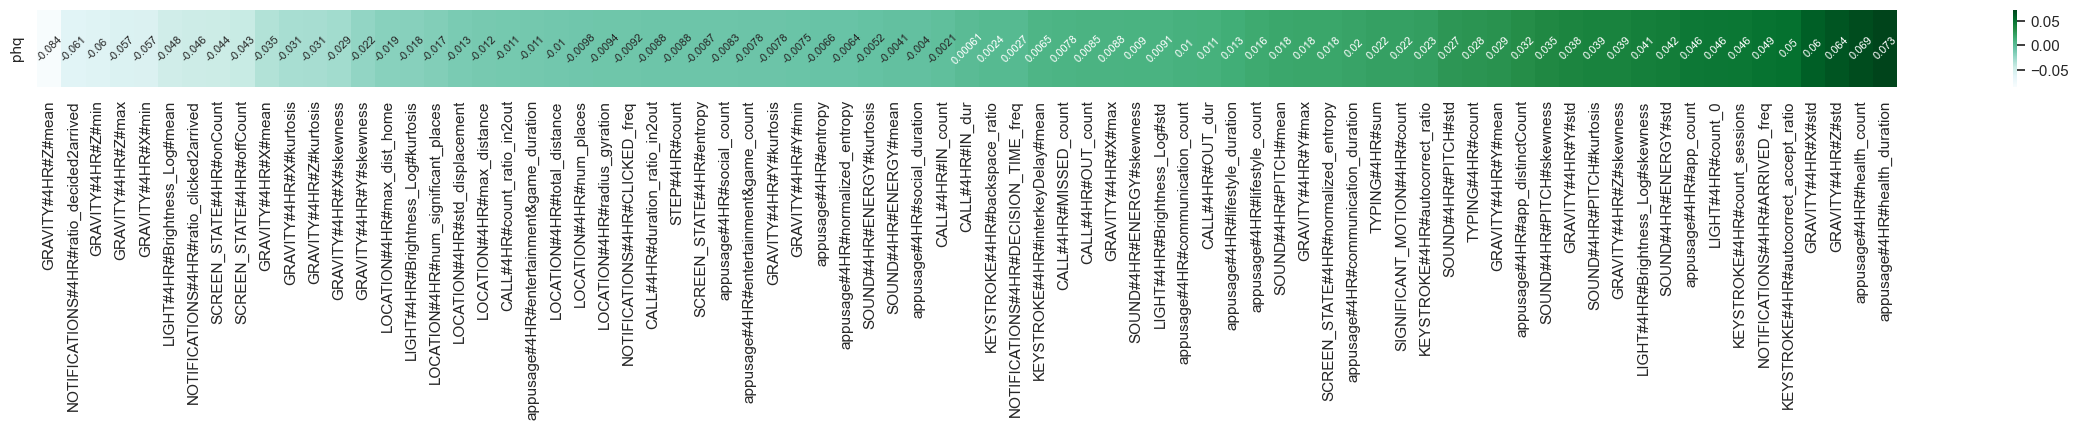

In [230]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(30,1)})
hm = sns.heatmap(aos_all_phq[:-1].transpose(), annot=True, annot_kws={'size': 8, 'rotation': 45}, xticklabels=True, yticklabels=True, cmap="BuGn")
#hm.set_xticklabels(hm.get_xticklabels(), rotation = 45, fontsize = 8)
plt.show()


#### Android: Normal

In [ ]:
sns.set(rc={'figure.figsize':(30,12)})
print(len(aos_norm_sig))
sns.heatmap(aos_norm_df_corr.loc[aos_norm_sig][aos_norm_sig], annot=True, annot_kws={'size': 10}, xticklabels=True, yticklabels=True, cmap="Blues")

<AxesSubplot:>

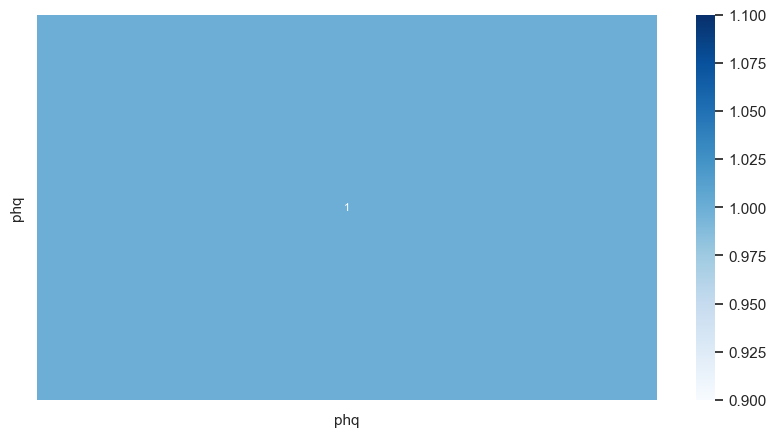

In [231]:
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(aos_norm_df_corr.loc[aos_norm_idx][aos_norm_idx], annot=True, annot_kws={'size': 8}, xticklabels=True, yticklabels=True, cmap="Blues")

In [232]:
aos_norm_phq = pd.DataFrame(aos_norm_df_corr['phq'])
aos_norm_phq.sort_values(by = 'phq', inplace=True)

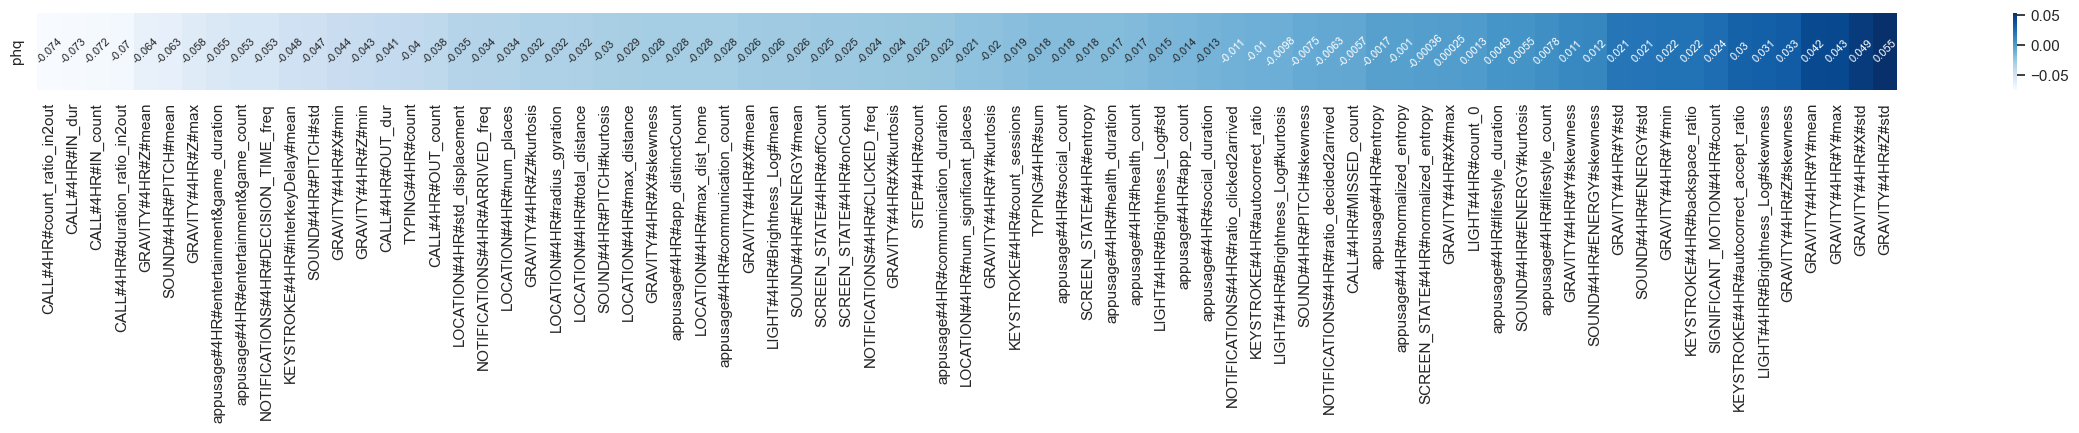

In [233]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(30,1)})
hm = sns.heatmap(aos_norm_phq[:-1].transpose(), annot=True, annot_kws={'size': 8, 'rotation': 45}, xticklabels=True, yticklabels=True, cmap="Blues")
#hm.set_xticklabels(hm.get_xticklabels(), rotation = 45, fontsize = 8)
plt.show()

#### Android: Mild

In [ ]:
sns.set(rc={'figure.figsize':(25,10)})
print(len(aos_mild_sig))
sns.heatmap(aos_mild_df_corr.loc[aos_mild_sig][aos_mild_sig], annot=True, annot_kws={'size': 10}, xticklabels=True, yticklabels=True, cmap="Oranges")

<AxesSubplot:>

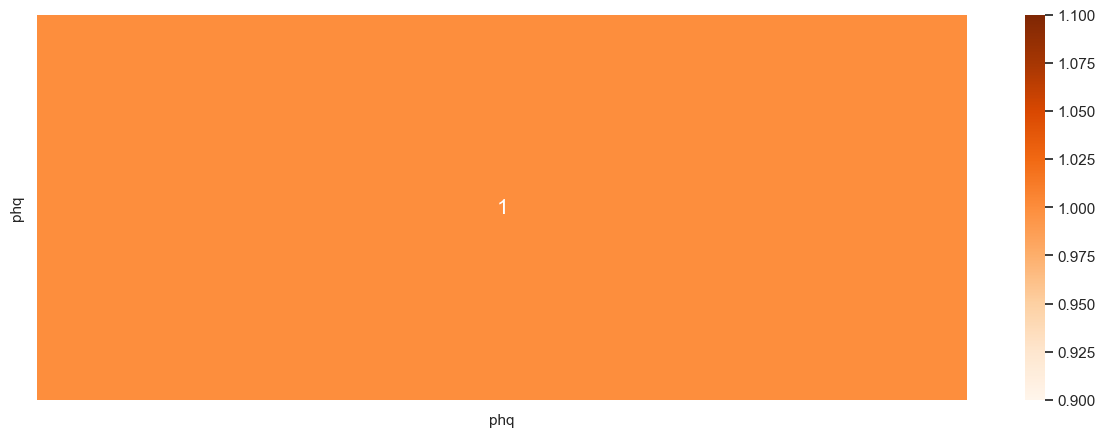

In [235]:
sns.set(rc={'figure.figsize':(15,5)})
sns.heatmap(aos_mild_df_corr.loc[aos_mild_idx][aos_mild_idx], annot=True, annot_kws={'size': 15}, xticklabels=True, yticklabels=True, cmap="Oranges")

In [236]:
aos_mild_phq = pd.DataFrame(aos_mild_df_corr['phq'])
aos_mild_phq.sort_values(by = 'phq', inplace=True)

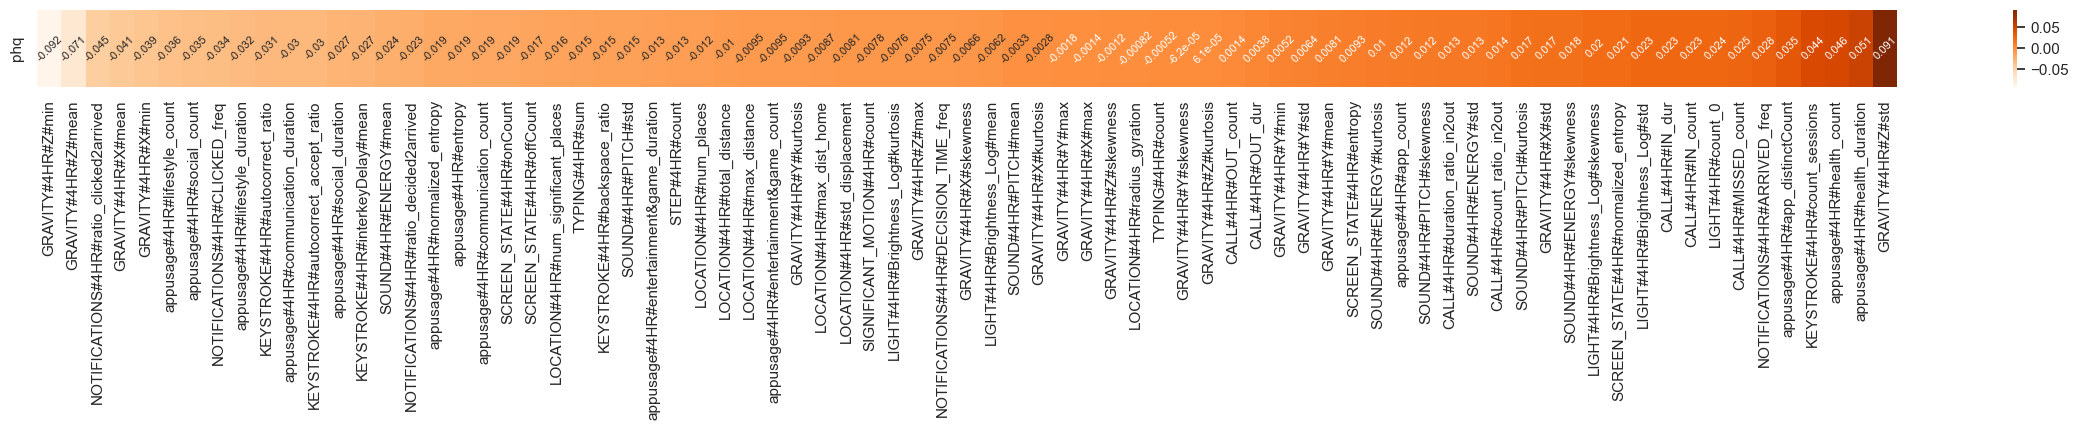

In [237]:
sns.set(rc={'figure.figsize':(30,1)})
hm = sns.heatmap(aos_mild_phq[:-1].transpose(), annot=True, annot_kws={'size': 8, 'rotation': 45}, xticklabels=True, yticklabels=True, cmap="Oranges")
#hm.set_xticklabels(hm.get_xticklabels(), rotation = 45, fontsize = 8)

#### Android: Severe

In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
print(len(aos_seve_sig))
sns.heatmap(aos_seve_df_corr.loc[aos_seve_sig][aos_seve_sig], annot=True, annot_kws={'size': 8}, xticklabels=True, yticklabels=True, cmap="Purples")

In [248]:
aos_seve_df['NOTIFICATIONS#4HR#ratio_decided2arrived']

pid  timestamp                          
14   2021-09-13 20:26:52.217999872+09:00    0.533333
     2021-09-16 12:09:20.220999936+09:00    0.361702
     2021-09-16 16:27:39.924999936+09:00    0.163880
     2021-09-16 20:11:52.897999872+09:00    0.247549
     2021-09-19 12:00:53.323000064+09:00    0.189055
                                              ...   
854  2022-02-09 12:01:05.713999872+09:00    0.800000
     2022-02-09 20:35:15.643000064+09:00    0.407801
     2022-02-12 12:23:39.492999936+09:00    0.285714
     2022-02-12 16:24:38.139000064+09:00    0.056818
     2022-02-12 20:04:14.287000064+09:00    0.461538
Name: NOTIFICATIONS#4HR#ratio_decided2arrived, Length: 6751, dtype: float64

[Text(0.5, 0, 'appusage#4HR#lifestyle_count'),
 Text(1.5, 0, 'NOTIFICATIONS#4HR#ARRIVED_freq'),
 Text(2.5, 0, 'NOTIFICATIONS#4HR#ratio_clicked2arrived'),
 Text(3.5, 0, 'NOTIFICATIONS#4HR#ratio_decided2arrived'),
 Text(4.5, 0, 'phq')]

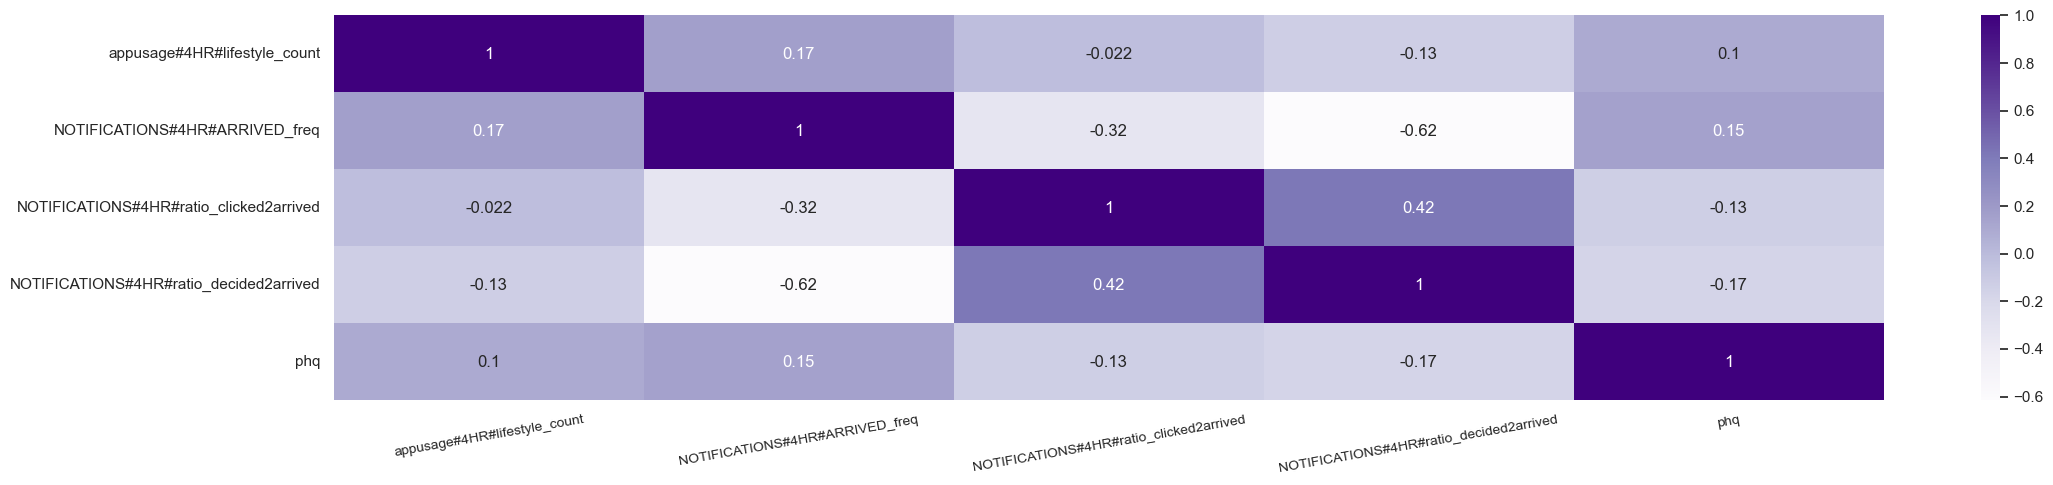

In [238]:
sns.set(rc={'figure.figsize':(25,5)})
hm = sns.heatmap(aos_seve_df_corr.loc[aos_seve_idx][aos_seve_idx], annot=True, annot_kws={'size': 12}, xticklabels=True, yticklabels=True, cmap="Purples")
hm.set_xticklabels(hm.get_xticklabels(), rotation = 10, fontsize = 10)

In [239]:
aos_seve_phq = pd.DataFrame(aos_seve_df_corr['phq'])
aos_seve_phq.sort_values(by = 'phq', inplace=True)

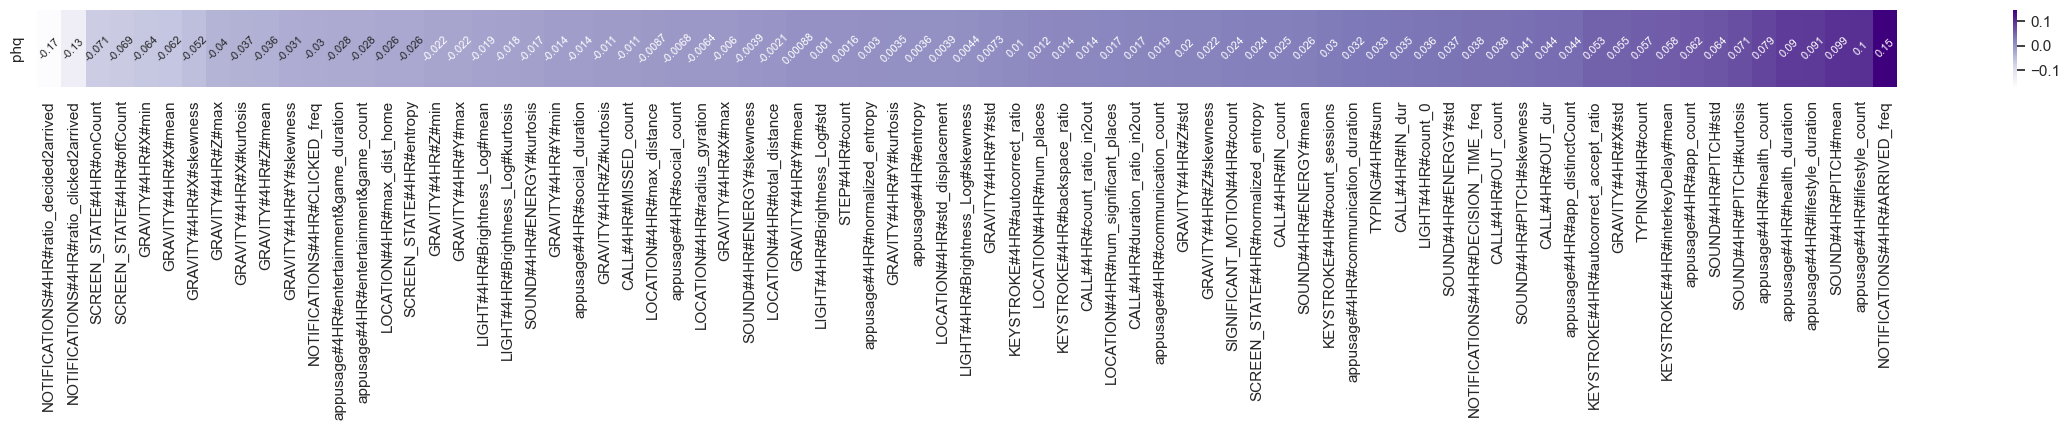

In [240]:
sns.set(rc={'figure.figsize':(30,1)})
hm = sns.heatmap(aos_seve_phq[:-1].transpose(), annot=True, annot_kws={'size': 8, 'rotation': 45}, xticklabels=True, yticklabels=True, cmap="Purples")
#hm.set_xticklabels(hm.get_xticklabels(), rotation = 70, fontsize = 8)
plt.show()

#### iOS

27


<AxesSubplot:>

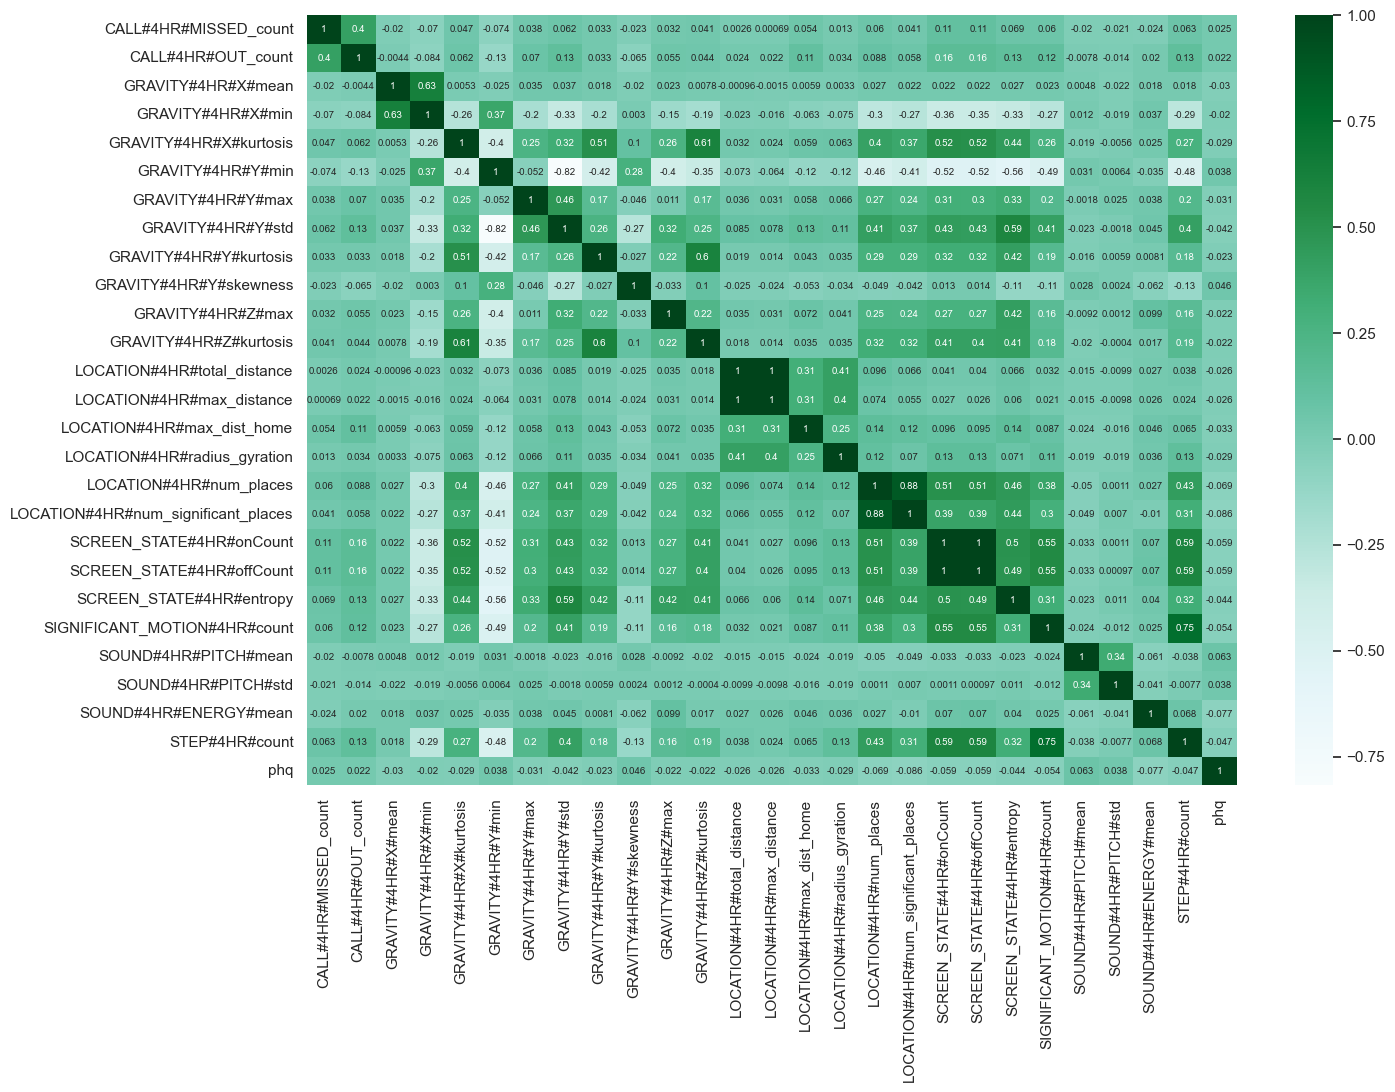

In [35]:
sns.set(rc={'figure.figsize':(15,10)})
print(len(ios_all_sig))
sns.heatmap(ios_group_corr.loc[ios_all_sig][ios_all_sig], annot=True, annot_kws={'size': 7}, xticklabels=True, yticklabels=True, cmap="BuGn")

13


<AxesSubplot:>

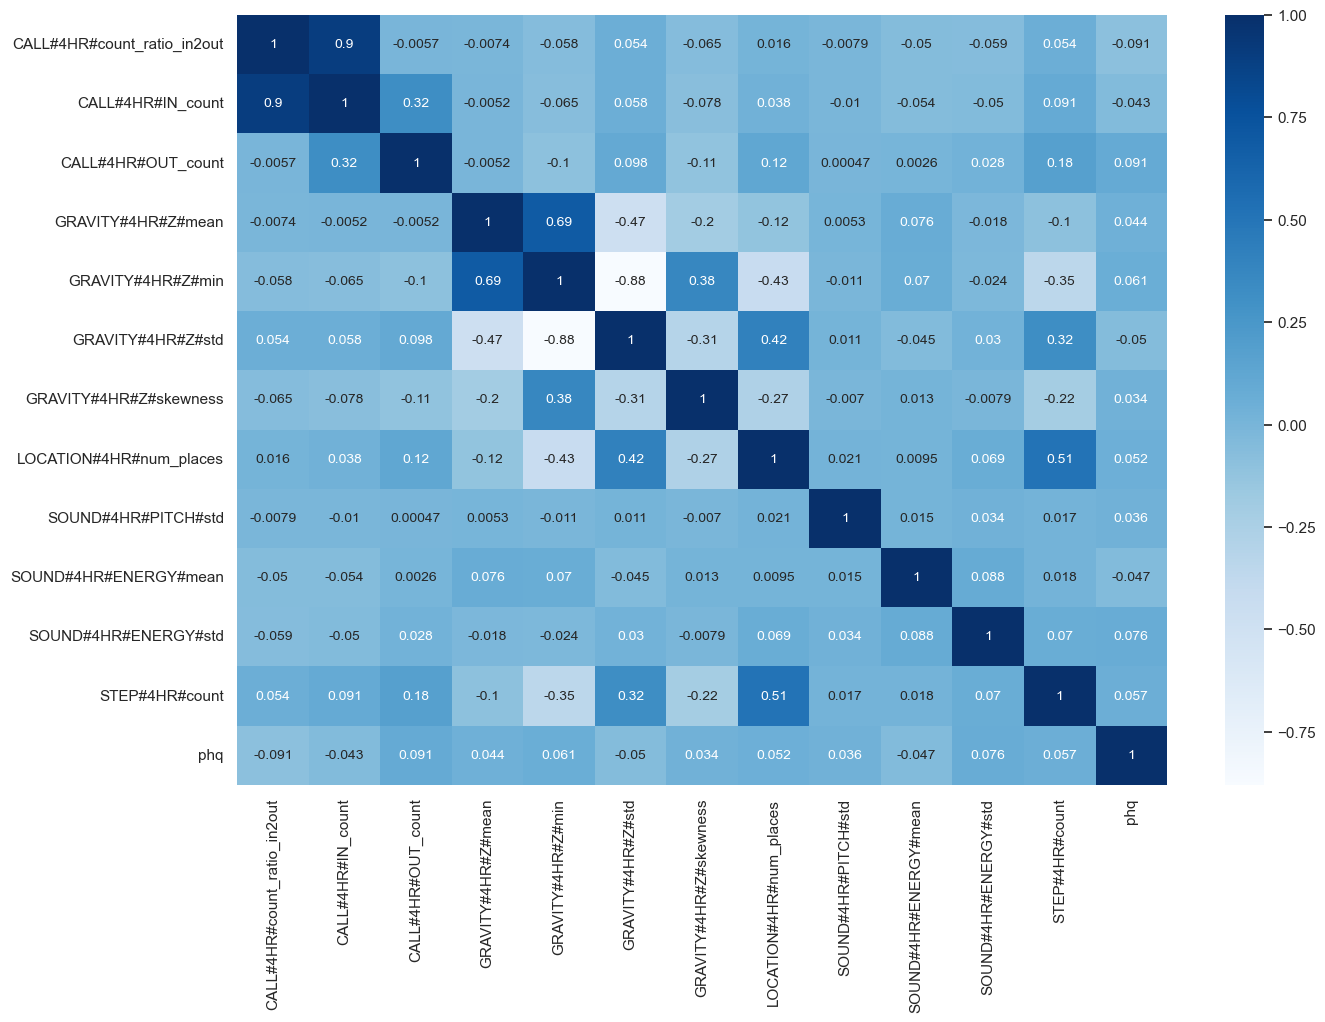

In [442]:
sns.set(rc={'figure.figsize':(15,10)})
print(len(ios_norm_sig))
sns.heatmap(ios_norm_df_corr.loc[ios_norm_sig][ios_norm_sig], annot=True, annot_kws={'size': 10}, xticklabels=True, yticklabels=True, cmap="Blues")

14


<AxesSubplot:>

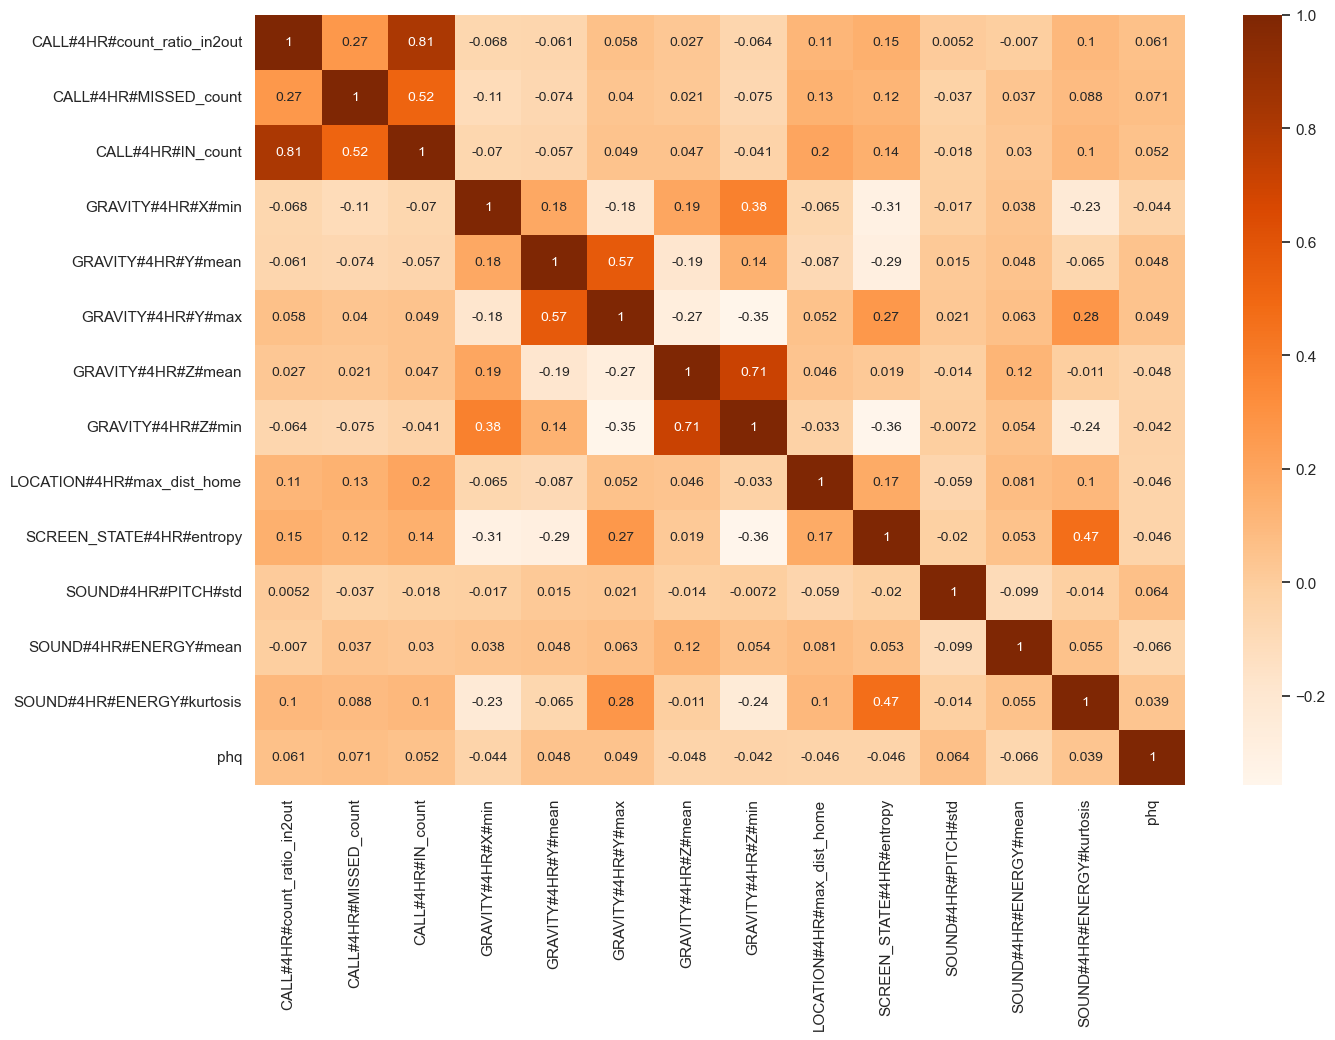

In [444]:
sns.set(rc={'figure.figsize':(15,10)})
print(len(ios_mild_sig))
sns.heatmap(ios_mild_df_corr.loc[ios_mild_sig][ios_mild_sig], annot=True, annot_kws={'size': 10}, xticklabels=True, yticklabels=True, cmap="Oranges")

31


<AxesSubplot:>

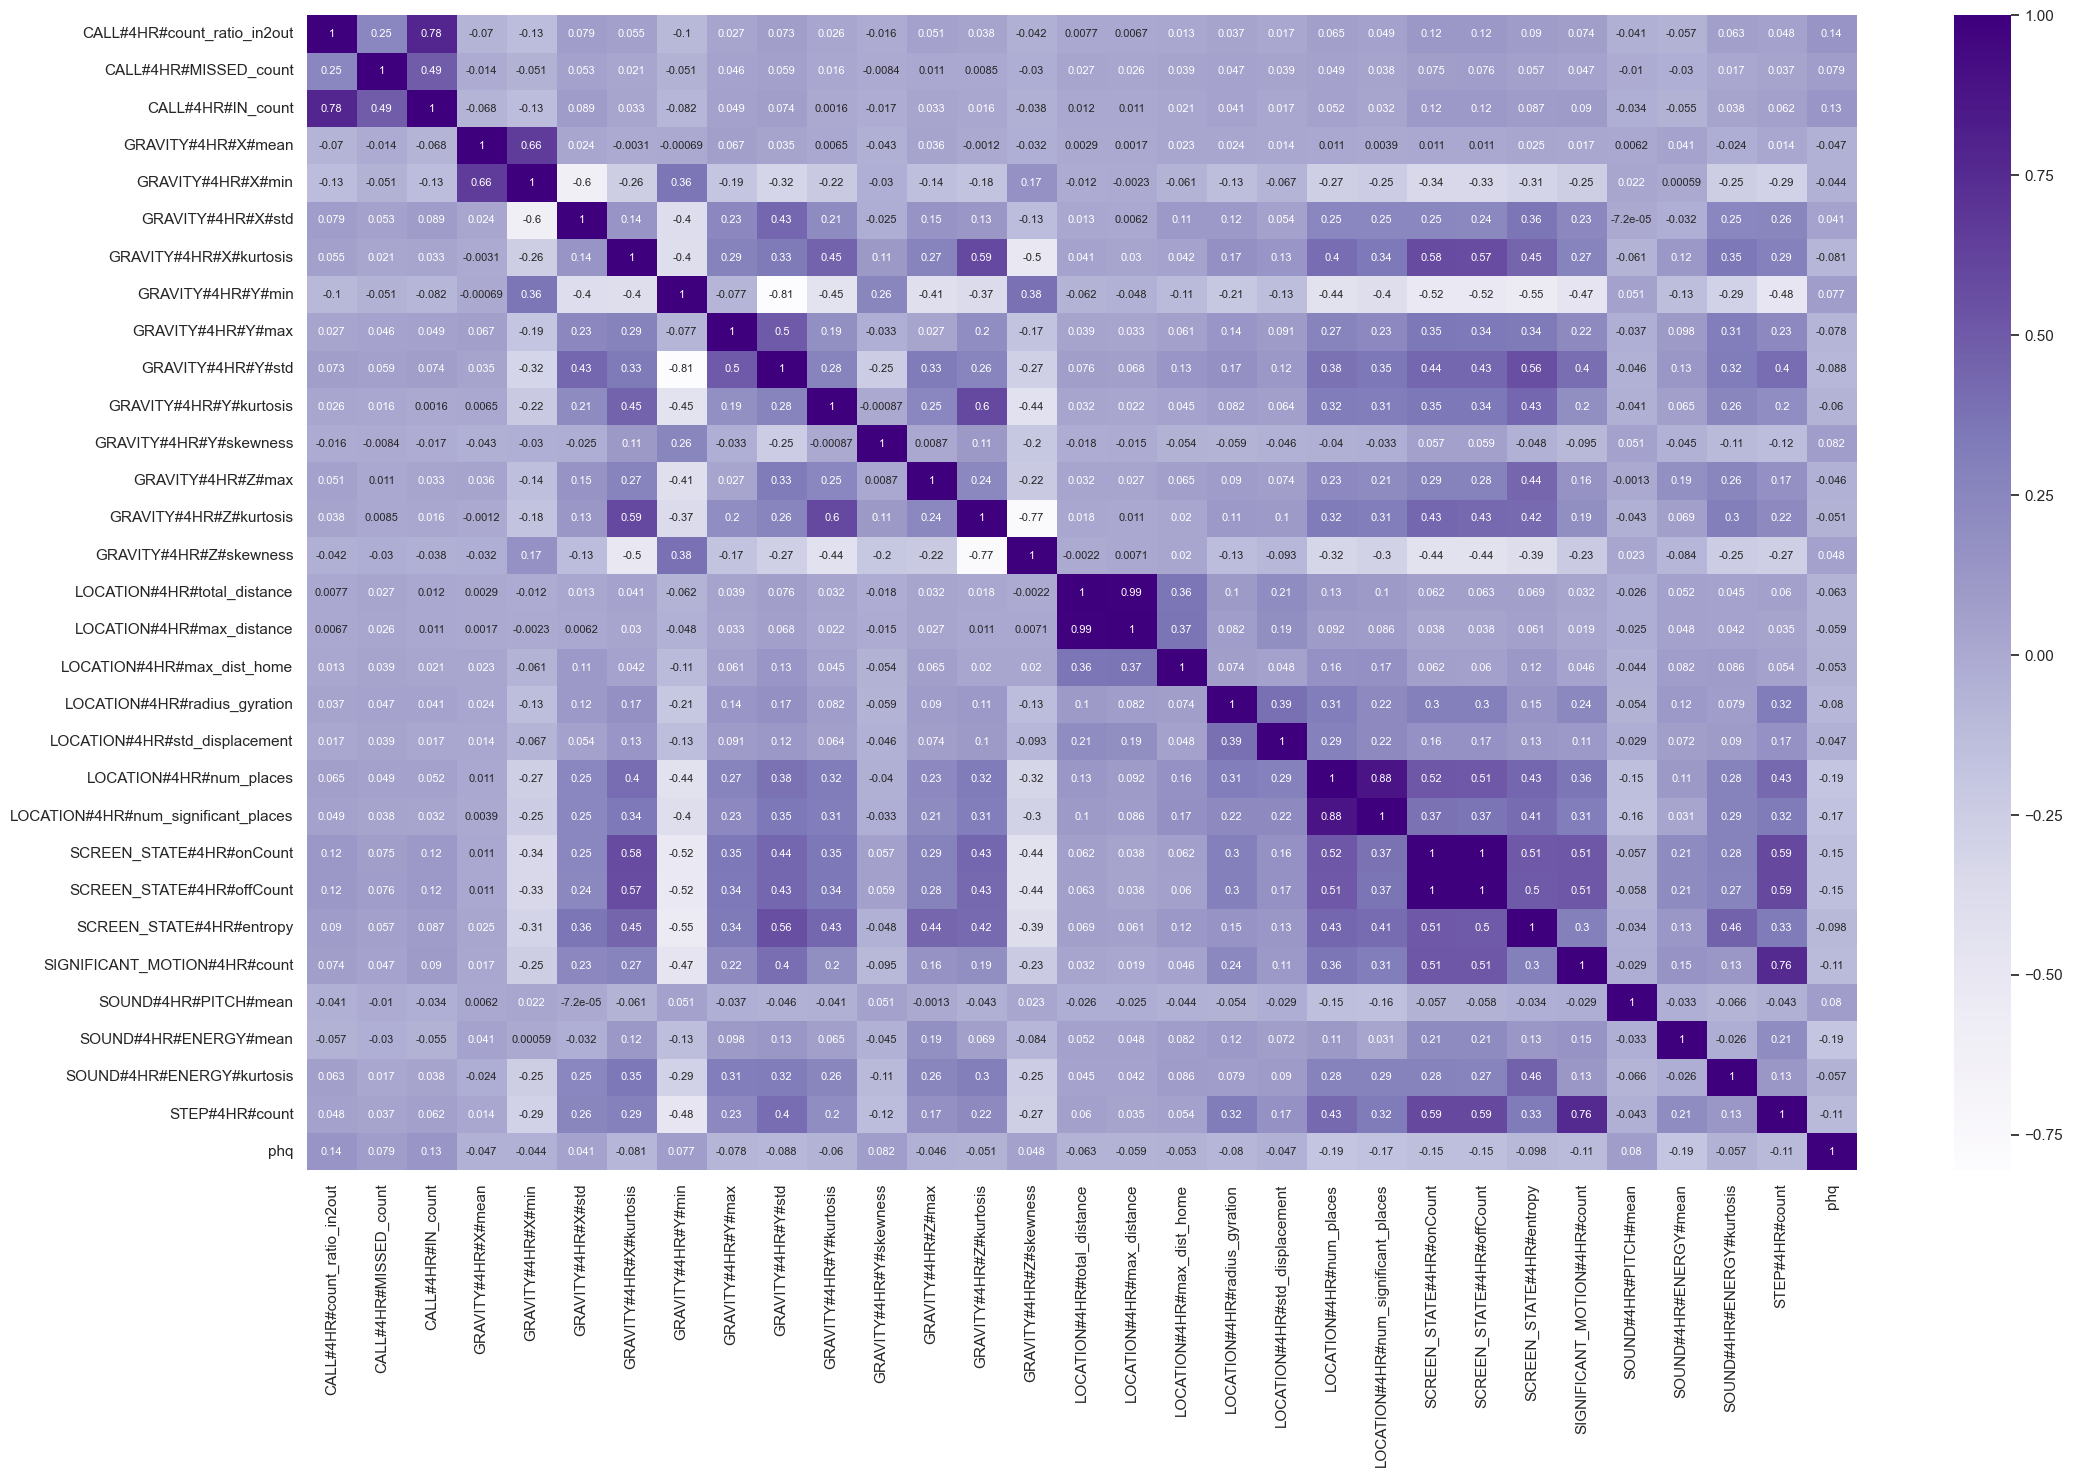

In [446]:
sns.set(rc={'figure.figsize':(25,15)})
print(len(ios_seve_sig))
sns.heatmap(ios_seve_df_corr.loc[ios_seve_sig][ios_seve_sig], annot=True, annot_kws={'size': 8}, xticklabels=True, yticklabels=True, cmap="Purples")

### Association

In [162]:
from sklearn.preprocessing import StandardScaler
scaler =  StandardScaler()

scaler.fit(aos_dataset)
aos_group_scaled = pd.DataFrame(scaler.transform(aos_dataset))
aos_group_scaled.columns = aos_dataset.columns 

scaler.fit(aos_norm_df)
aos_norm_df_scaled = pd.DataFrame(scaler.transform(aos_norm_df))
aos_norm_df_scaled.columns = aos_norm_df.columns 

scaler.fit(aos_mild_df)
aos_mild_df_scaled = pd.DataFrame(scaler.transform(aos_mild_df))
aos_mild_df_scaled.columns = aos_mild_df.columns 

scaler.fit(aos_seve_df)
aos_seve_df_scaled = pd.DataFrame(scaler.transform(aos_seve_df))
aos_seve_df_scaled.columns = aos_seve_df.columns 

#aos_dataset.reset_index(inplace=True, drop=True)
scaler.fit(aos_dataset)
aos_group_scaled = pd.DataFrame(scaler.transform(aos_dataset))
aos_group_scaled.columns = aos_dataset.columns 

scaler =  StandardScaler()

scaler.fit(ios_dataset)
ios_group_scaled = pd.DataFrame(scaler.transform(ios_dataset))
ios_group_scaled.columns = ios_dataset.columns 

scaler.fit(ios_norm_df)
ios_norm_df_scaled = pd.DataFrame(scaler.transform(ios_norm_df))
ios_norm_df_scaled.columns = ios_norm_df.columns 

scaler.fit(ios_mild_df)
ios_mild_df_scaled = pd.DataFrame(scaler.transform(ios_mild_df))
ios_mild_df_scaled.columns = ios_mild_df.columns 

scaler.fit(ios_seve_df)
ios_seve_df_scaled = pd.DataFrame(scaler.transform(ios_seve_df))
ios_seve_df_scaled.columns = ios_seve_df.columns 

#ios_dataset.reset_index(inplace=True, drop=True)
scaler.fit(ios_dataset)
ios_group_scaled = pd.DataFrame(scaler.transform(ios_dataset))
ios_group_scaled.columns = ios_dataset.columns 

In [163]:
aos_group_median = aos_group_scaled.describe().loc['50%']
aos_norm_median = aos_norm_df_scaled.describe().loc['50%']
aos_mild_median = aos_mild_df_scaled.describe().loc['50%']
aos_seve_median = aos_seve_df_scaled.describe().loc['50%']

ios_group_median = ios_group_scaled.describe().loc['50%']
ios_norm_median = ios_norm_df_scaled.describe().loc['50%']
ios_mild_median = ios_mild_df_scaled.describe().loc['50%']
ios_seve_median = ios_seve_df_scaled.describe().loc['50%']


In [164]:
aos_asso_matrix = pd.DataFrame()
aos_asso_matrix['all-normal'] = aos_group_median - aos_norm_median
aos_asso_matrix['all-mild'] = aos_group_median - aos_mild_median
aos_asso_matrix['all-severe'] = aos_group_median - aos_seve_median
aos_asso_matrix['normal-mild'] = aos_norm_median - aos_mild_median
aos_asso_matrix['mild-severe'] = aos_mild_median - aos_seve_median
aos_asso_matrix['normal-severe'] = aos_norm_median - aos_seve_median

ios_asso_matrix = pd.DataFrame()
ios_asso_matrix['all-normal'] = ios_group_median - ios_norm_median
ios_asso_matrix['all-mild'] = ios_group_median - ios_mild_median
ios_asso_matrix['all-severe'] = ios_group_median - ios_seve_median
ios_asso_matrix['normal-mild'] = ios_norm_median - ios_mild_median
ios_asso_matrix['mild-severe'] = ios_mild_median - ios_seve_median
ios_asso_matrix['normal-severe'] = ios_norm_median - ios_seve_median

In [174]:
aos_asso_matrix.describe()

all-normal   all-mild  all-severe  normal-mild  mild-severe  \
count   78.000000  78.000000   78.000000    78.000000    78.000000   
mean     0.008032   0.004214   -0.004084    -0.003818    -0.008298   
std      0.049632   0.044455    0.075570     0.036067     0.074873   
min     -0.057813  -0.116610   -0.519166    -0.146235    -0.402556   
25%     -0.018006  -0.010609   -0.012576    -0.017193    -0.012730   
50%     -0.003021   0.000114    0.007346     0.002918     0.005456   
75%      0.015625   0.011395    0.019836     0.018339     0.021911   
max      0.324704   0.331815    0.150543     0.061045     0.136179   

       normal-severe  
count      78.000000  
mean       -0.012115  
std         0.087092  
min        -0.495332  
25%        -0.026051  
50%         0.004208  
75%         0.035582  
max         0.116471

<AxesSubplot:>

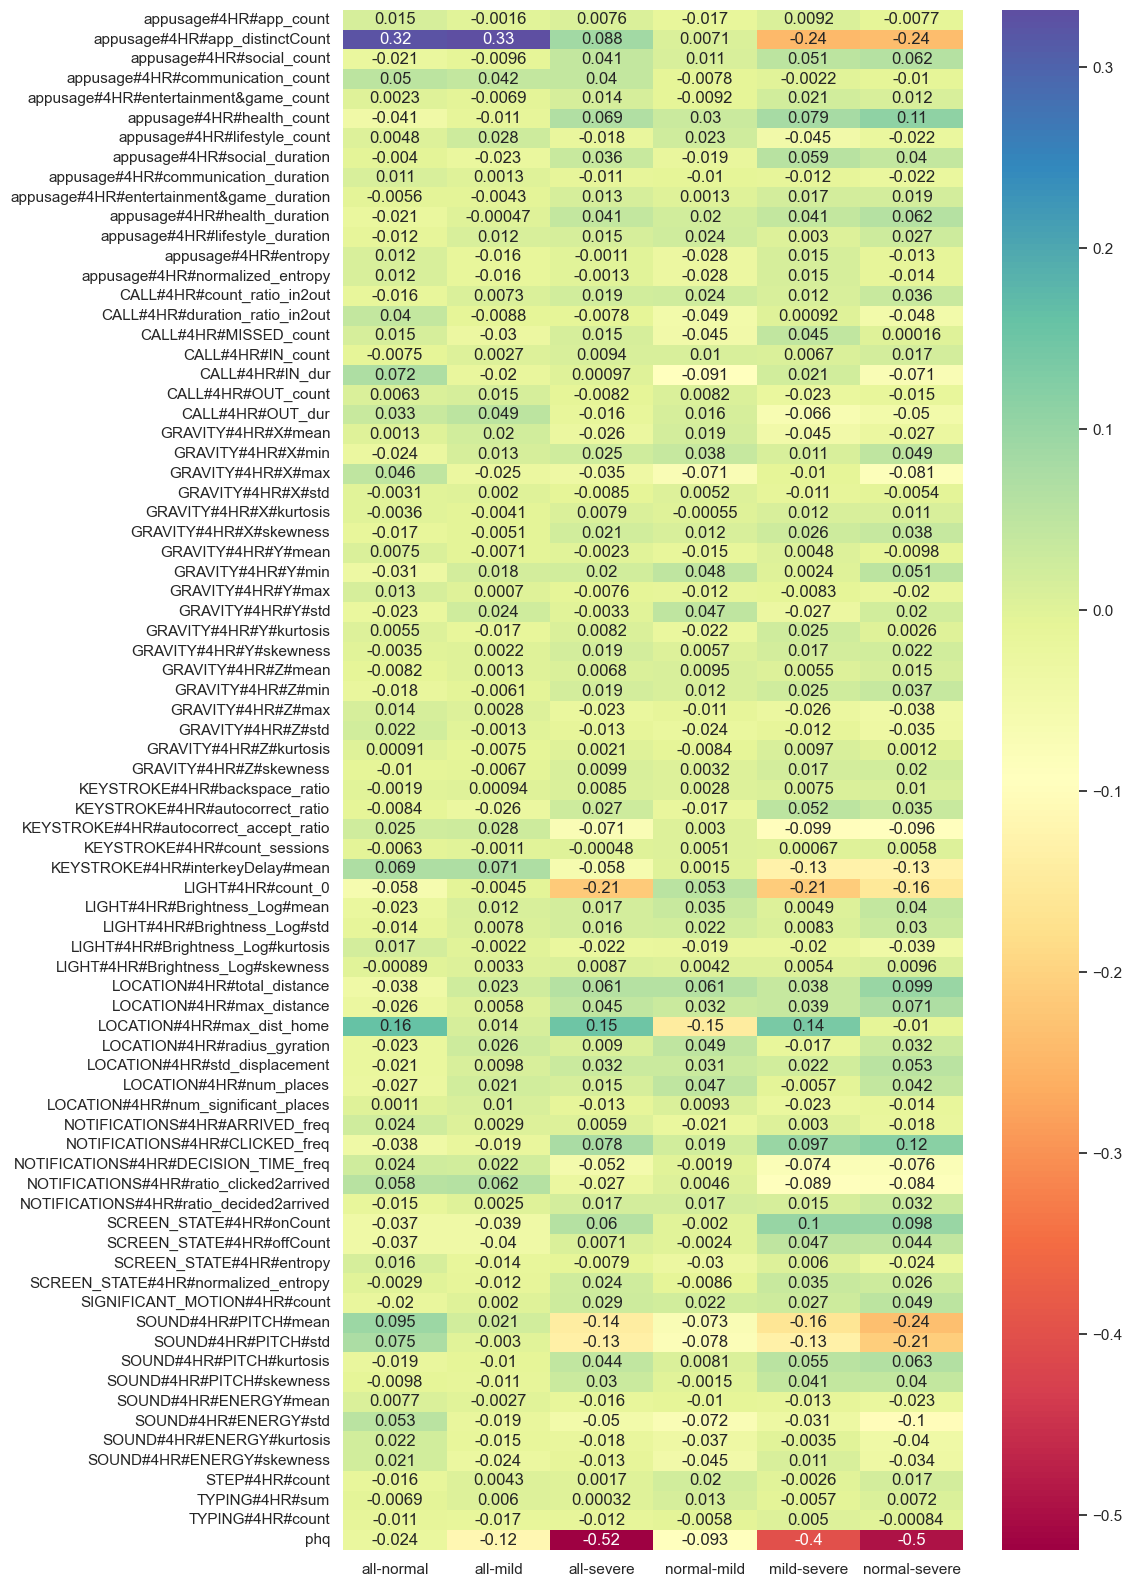

In [183]:
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(aos_asso_matrix, annot=True, cmap = 'Spectral', xticklabels=True, yticklabels=True)

<AxesSubplot:>

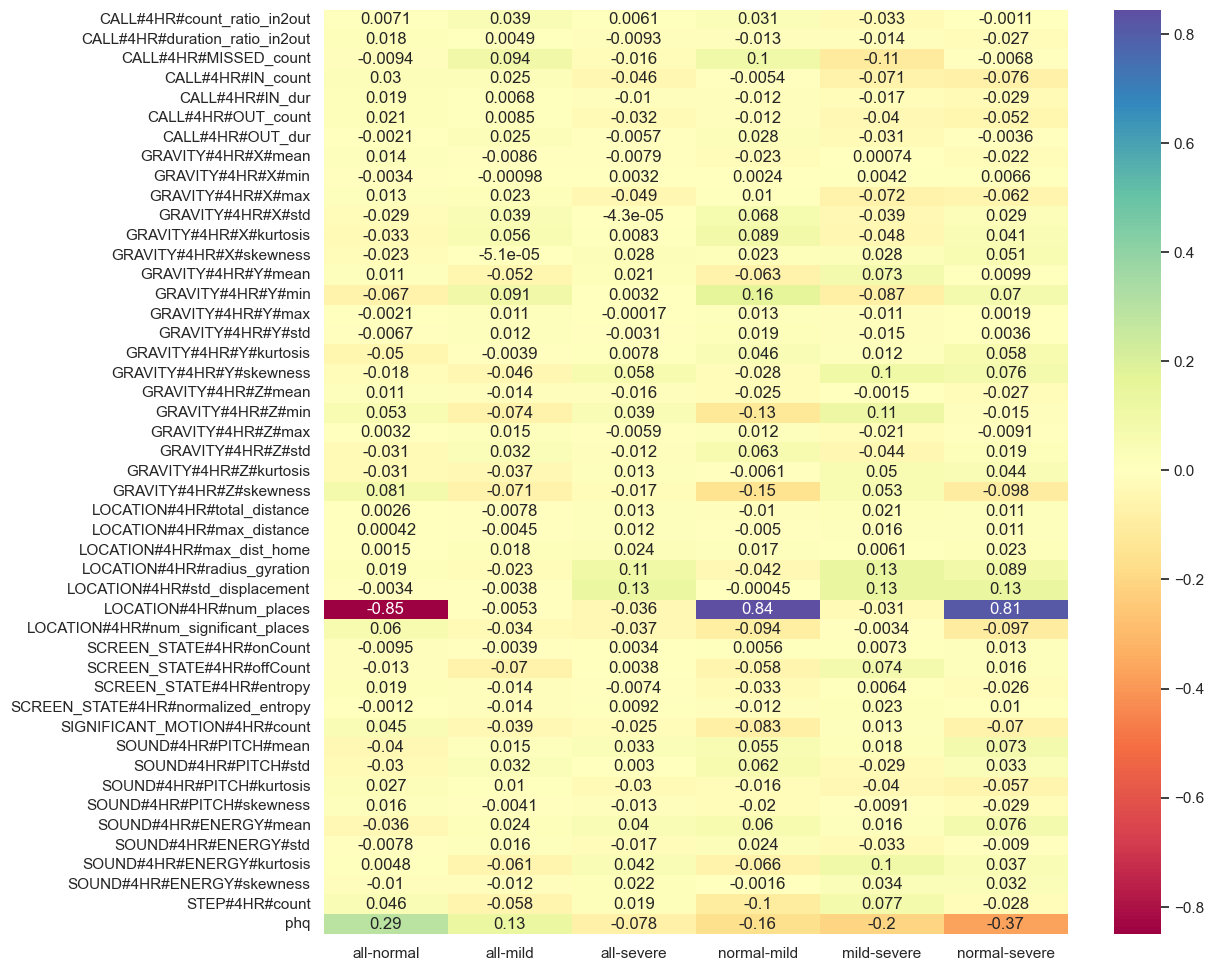

In [73]:
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(ios_asso_matrix, annot=True, cmap = 'Spectral', xticklabels=True, yticklabels=True)

In [366]:
asso_matrix

all-normal      all-mild    all-severe  \
CALL#4HR#count_ratio_in2out          4.190309e-16 -5.103191e-15 -3.760711e-15   
CALL#4HR#duration_ratio_in2out       1.136437e-15  1.091554e-15  1.381770e-15   
CALL#4HR#MISSED_count                3.331042e-15  9.580317e-16  7.457936e-16   
CALL#4HR#IN_count                   -1.006587e-14 -7.837914e-15 -6.429398e-15   
CALL#4HR#IN_dur                     -7.125622e-16  4.773674e-16  2.573406e-16   
CALL#4HR#OUT_count                   1.702910e-15 -1.338121e-16  2.710137e-16   
CALL#4HR#OUT_dur                     8.087216e-16  9.225980e-16  1.048873e-15   
GRAVITY#4HR#X#mean                  -2.250937e-17  8.286528e-17  1.541514e-17   
GRAVITY#4HR#X#min                    1.516280e-17 -1.129182e-16 -6.489607e-17   
GRAVITY#4HR#X#max                   -1.420405e-16 -7.408600e-17 -3.009132e-17   
GRAVITY#4HR#X#std                   -1.307388e-16 -2.095251e-17  1.315801e-16   
GRAVITY#4HR#X#kurtosis              -2.557516e-17  7.128525e-16  1.008807e-15   
GRAVITY#4HR#X#skewness              -1.858166e-16 -2.851614e-16 -2.008972e-16   
GRAVITY#4HR#Y#mean                  -2.230516e-16  1.473689e-17 -4.005154e-18   
GRAVITY#4HR#Y#min                    4.051573e-17 -1.096284e-17 -2.829252e-17   
GRAVITY#4HR#Y#max                   -9.605861e-17 -1.119162e-16 -1.900017e-16   
GRAVITY#4HR#Y#std                   -1.343722e-16 -1.770404e-16 -1.421148e-16   
GRAVITY#4HR#Y#kurtosis               3.813729e-16  4.210944e-17  6.278590e-16   
GRAVITY#4HR#Y#skewness              -4.810438e-18 -1.083411e-16 -1.616550e-16   
GRAVITY#4HR#Z#mean                  -1.964395e-16  1.450460e-17 -1.410128e-16   
GRAVITY#4HR#Z#min                   -1.636298e-17  7.789435e-17 -4.113590e-17   
GRAVITY#4HR#Z#max                    2.504250e-16 -3.071287e-17  3.620477e-16   
GRAVITY#4HR#Z#std                   -4.360179e-17 -4.281755e-17 -2.769394e-16   
GRAVITY#4HR#Z#kurtosis              -1.678592e-16 -4.563902e-16 -9.423059e-16   
GRAVITY#4HR#Z#skewness               8.822249e-16  5.112135e-16  1.662838e-15   
LOCATION#4HR#total_distance         -2.358336e-15 -2.308672e-15 -1.993267e-15   
LOCATION#4HR#max_distance            1.083239e-15  7.547419e-16  1.330432e-15   
LOCATION#4HR#max_dist_home          -1.983558e-16 -1.047754e-15  1.299512e-16   
LOCATION#4HR#radius_gyration        -2.217025e-15 -2.263470e-15 -2.788537e-15   
LOCATION#4HR#std_displacement        1.781509e-15  6.174215e-16  1.718325e-15   
LOCATION#4HR#num_places              5.867435e-16  4.935299e-16  1.480831e-15   
LOCATION#4HR#num_significant_places  1.338021e-15 -2.398293e-15 -1.082059e-15   
SCREEN_STATE#4HR#onCount            -3.440313e-16 -1.742433e-15 -1.439091e-15   
SCREEN_STATE#4HR#offCount            2.276460e-16 -4.109772e-17  2.432077e-16   
SCREEN_STATE#4HR#entropy             1.087240e-15  9.200481e-17  1.479767e-15   
SCREEN_STATE#4HR#normalized_entropy  2.456136e-15  1.437019e-15  1.706375e-15   
SIGNIFICANT_MOTION#4HR#count        -9.502323e-16 -8.980409e-16 -1.294669e-15   
SOUND#4HR#PITCH#mean                 1.896947e-17  3.689599e-17  5.970403e-17   
SOUND#4HR#PITCH#std                 -9.147409e-17  7.385483e-17 -8.112279e-17   
SOUND#4HR#PITCH#kurtosis             2.058415e-15  4.270151e-15  2.936736e-15   
SOUND#4HR#PITCH#skewness             1.837029e-15  7.402420e-16  2.273790e-16   
SOUND#4HR#ENERGY#mean               -7.116907e-17  7.064588e-16  6.120141e-16   
SOUND#4HR#ENERGY#std                 2.359996e-16  1.229791e-16  3.778289e-16   
SOUND#4HR#ENERGY#kurtosis            2.815942e-15  2.894680e-15  2.500740e-15   
SOUND#4HR#ENERGY#skewness           -9.427377e-16 -5.161197e-16 -9.674276e-16   
STEP#4HR#count                       3.820861e-15  3.634007e-15  3.581810e-15   
phq                                  8.751466e-16  1.074768e-15  9.927326e-16   

                                      normal-mild   mild-severe  normal-severe  
CALL#4HR#count_ratio_in2out         -5.522222e-15  1.342479e-15  -4.1

### Visualization

In [10]:
len(df_group.loc[df_group.SCREENING == 'normal'])/len(df_group)

0.44155844155844154

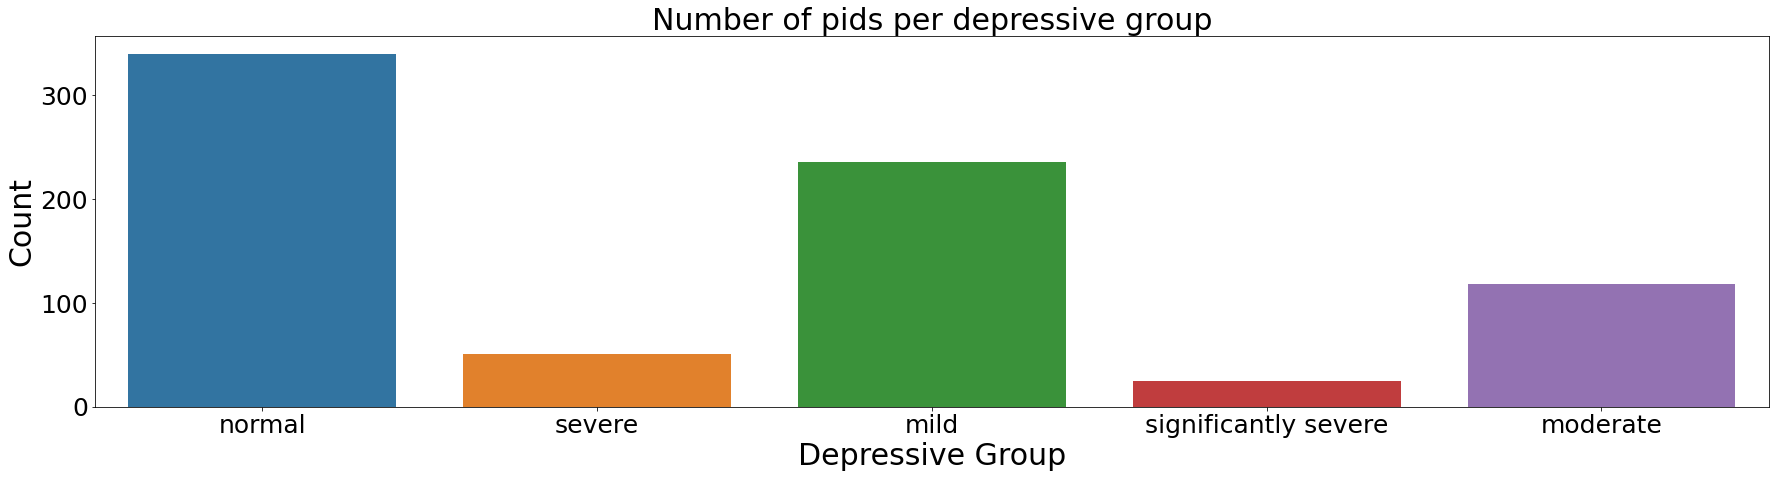

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 15))
ax = fig.add_axes([0,0,1,1])
plt.subplot(2, 1, 1)

plt.tick_params(labelsize = 25)
sns.countplot(x = 'SCREENING',  data = df_group)
plt.title("Number of pids per depressive group", fontsize = 30)
plt.xlabel("Depressive Group", fontsize = 30)
plt.ylabel("Count", fontsize = 30)
plt.show()

In [19]:
df_group_3 = df_group.copy()
df_group_3['SCREENING'] = df_group_3['SCREENING'].apply(lambda x : 'depressed' if x =='moderate' else x) 
df_group_3['SCREENING'] = df_group_3['SCREENING'].apply(lambda x : 'depressed' if x =='severe' else x) 
df_group_3['SCREENING'] = df_group_3['SCREENING'].apply(lambda x : 'depressed' if x =='significantly severe' else x) 

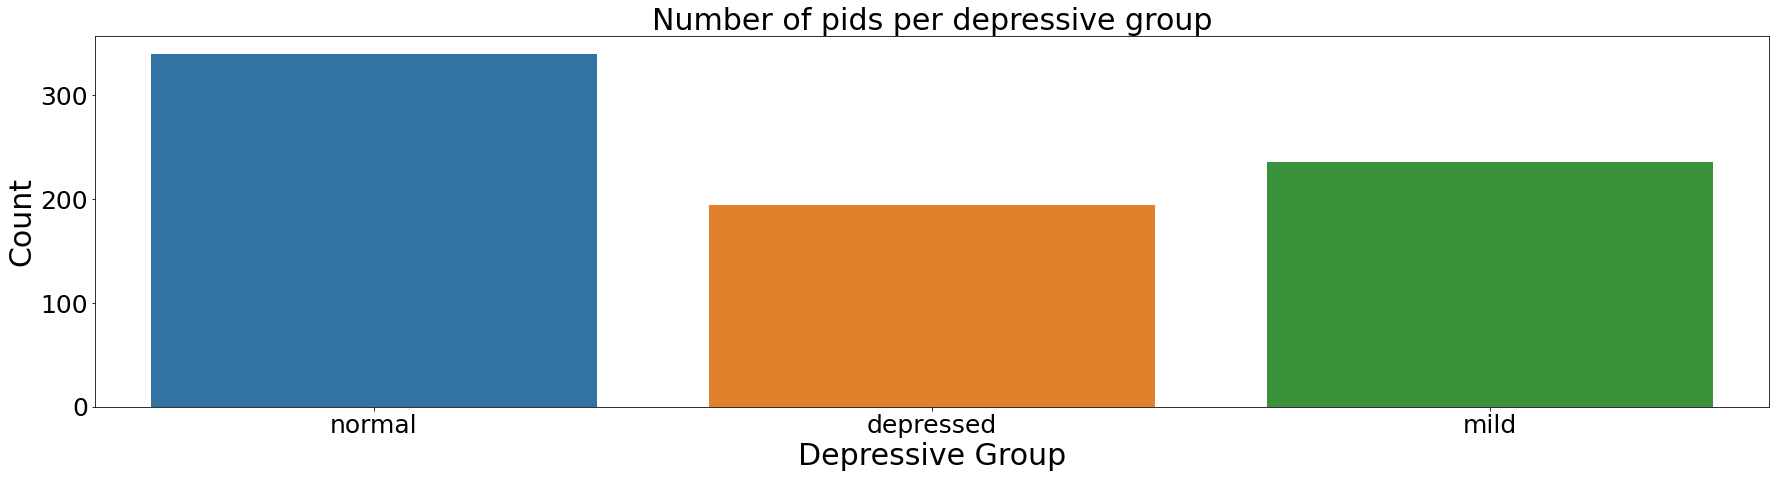

In [15]:
fig = plt.figure(figsize = (30, 15))
ax = fig.add_axes([0,0,1,1])
plt.subplot(2, 1, 1)

plt.tick_params(labelsize = 25)
sns.countplot(x = 'SCREENING',  data = df_group_3)
plt.title("Number of pids per depressive group", fontsize = 30)
plt.xlabel("Depressive Group", fontsize = 30)
plt.ylabel("Count", fontsize = 30)
plt.show()

## Demographics

### Age

In [21]:
df_group_3['age'] = 2022 - pd.to_datetime(df_group_3['BIRTHDAY']).dt.year

In [22]:
nor_group = df_group_3.loc[df_group_3.SCREENING=='normal']
mild_group = df_group_3.loc[df_group_3.SCREENING=='mild']
dep_group = df_group_3.loc[df_group_3.SCREENING=='depressed']


In [23]:
print('# of female:',len(df_group_3.loc[df_group_3['GENDER']=='여']),'   # of male:', len(df_group_3.loc[df_group_3['GENDER']=='남']))

# of female: 443    # of male: 322


In [26]:
len(set(df_group_3['ID']))

770

In [28]:
df_group_3['ID']

0        6
1       14
2       20
3       21
4       26
      ... 
765    867
766    873
767    876
768    878
769    879
Name: ID, Length: 770, dtype: object

### Gender Distribution

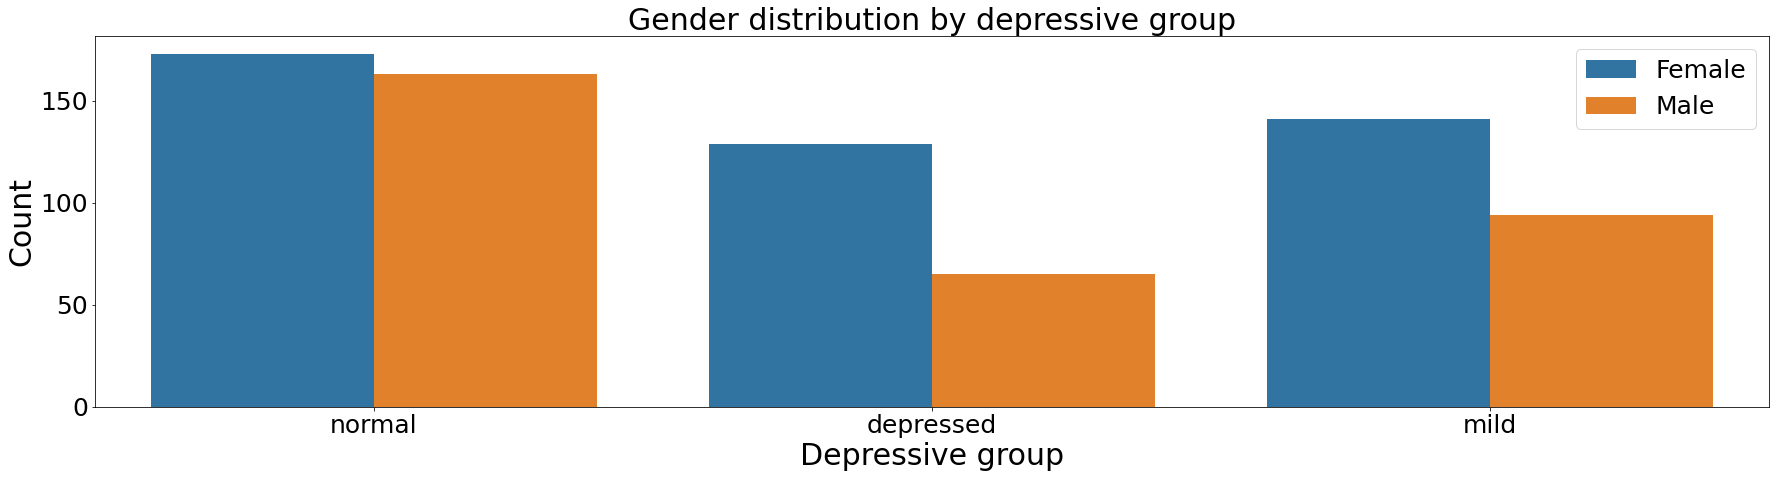

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 15))
ax = fig.add_axes([0,0,1,1])
plt.subplot(2, 1, 1)

plt.tick_params(labelsize = 25)
sns.countplot(x = 'SCREENING', hue ='GENDER', data = df_group_3)
plt.title("Gender distribution by depressive group", fontsize = 30)
plt.xlabel("Depressive group", fontsize = 30)
plt.ylabel("Count", fontsize = 30)
plt.legend(labels=['Female', 'Male'], fontsize = 25)
plt.show()

### Age Distribution

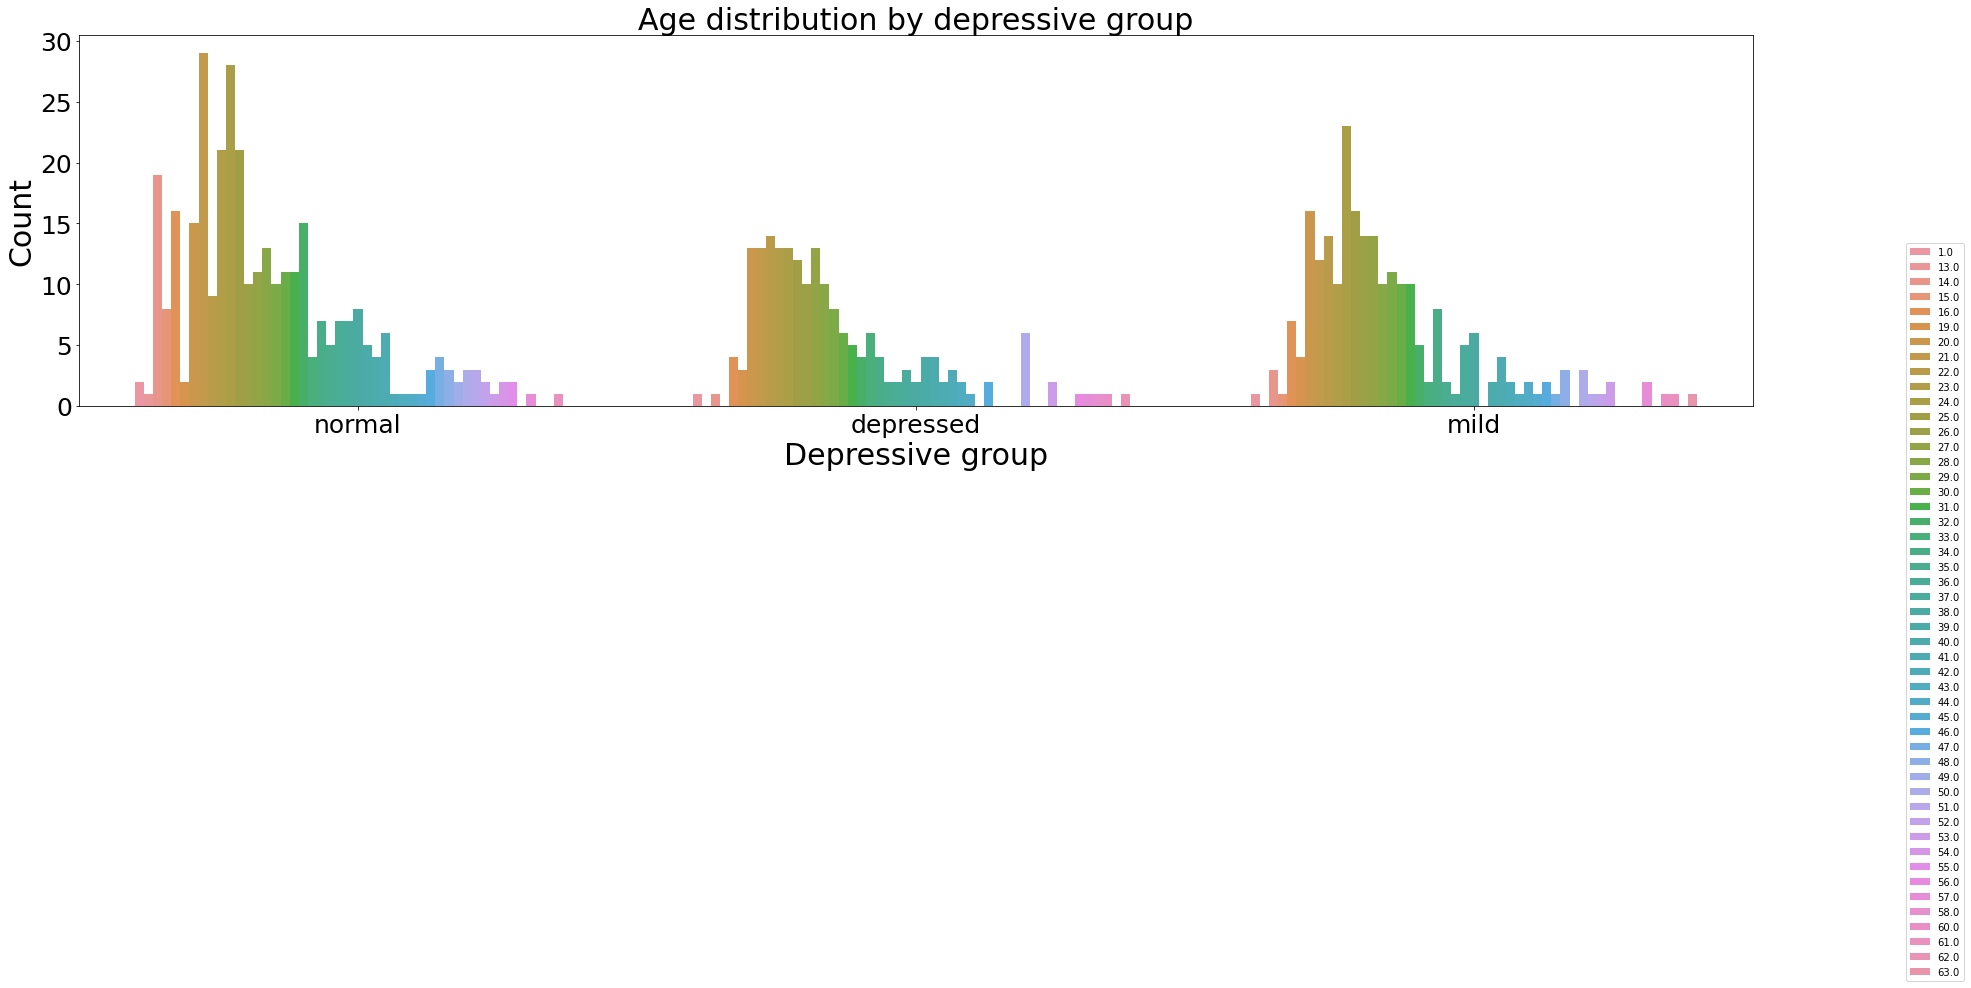

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 15))
ax = fig.add_axes([0,0,1,1])
plt.subplot(2, 1, 1)

plt.tick_params(labelsize = 25)
sns.countplot(x = 'SCREENING', hue ='age', data = df_group_3)
plt.title("Age distribution by depressive group", fontsize = 30)
plt.xlabel("Depressive group", fontsize = 30)
plt.ylabel("Count", fontsize = 30)
plt.legend(loc = 'lower right', bbox_to_anchor=(1, 0), bbox_transform =fig.transFigure)
plt.show()

In [75]:
print('age statistics of normal group:', nor_group.describe())
print('age statistics of normal group:', mild_group.describe())
print('age statistics of normal group:', dep_group.describe())



age statistics of normal group: 0             age
count  336.000000
mean    27.806548
std      9.947688
min      1.000000
25%     21.000000
50%     25.000000
75%     32.250000
max     61.000000
age statistics of normal group: 0             age
count  235.000000
mean    28.595745
std      9.434116
min      1.000000
25%     23.000000
50%     26.000000
75%     31.500000
max     63.000000
age statistics of normal group: 0             age
count  193.000000
mean    28.922280
std      9.560616
min      1.000000
25%     22.000000
50%     26.000000
75%     33.000000
max     62.000000


In [73]:
nor_group

0     ID   NAME  GENDER             BIRTHDAY SCREENING
0      6     정미리      여  1988-12-18 00:00:00    normal
2     20     권채연      여  1996-05-06 00:00:00    normal
4     26     임춘희      여  1977-10-13 00:00:00    normal
5     28     문정윤      여  2000-04-29 00:00:00    normal
7     36     홍다현      남  1995-09-12 00:00:00    normal
..   ...     ...    ...                  ...       ...
763  863  안준서_AB      남  2007-06-10 00:00:00    normal
764  865  한수민_AB    NaN                  NaN    normal
765  867  최민성_AB      남  2008-04-16 00:00:00    normal
768  878     박지민      남  2008-01-01 00:00:00    normal
769  879     정현기      남  2007-10-02 00:00:00    normal

[340 rows x 5 columns]

### Gender

In [45]:
df_pids.index = df_pids['BASIC INFORMATION'] 
df_pids = df_pids.loc[aos_pids]
male_pids = list(df_pids[df_pids['Unnamed: 4']=='남'].index)
female_pids = list(df_pids[df_pids['Unnamed: 4']=='여'].index)

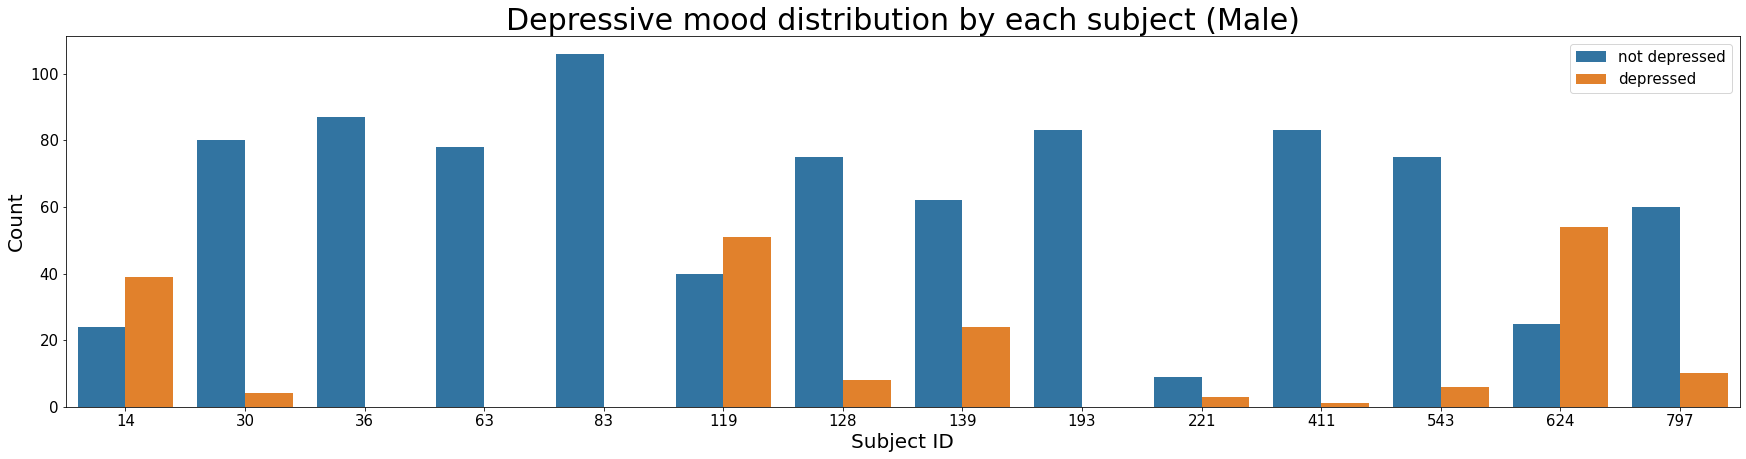

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 15))
ax = fig.add_axes([0,0,1,1])
plt.subplot(2, 1, 1)

plt.tick_params(labelsize = 15)
sns.countplot(x = 'pid', hue ='depressed', data = aos_ema.loc[male_pids].reset_index())
plt.title("Depressive mood distribution by each subject (Male)", fontsize = 30)
plt.xlabel("Subject ID", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.legend(labels=['not depressed', 'depressed'], fontsize = 15)
plt.show()

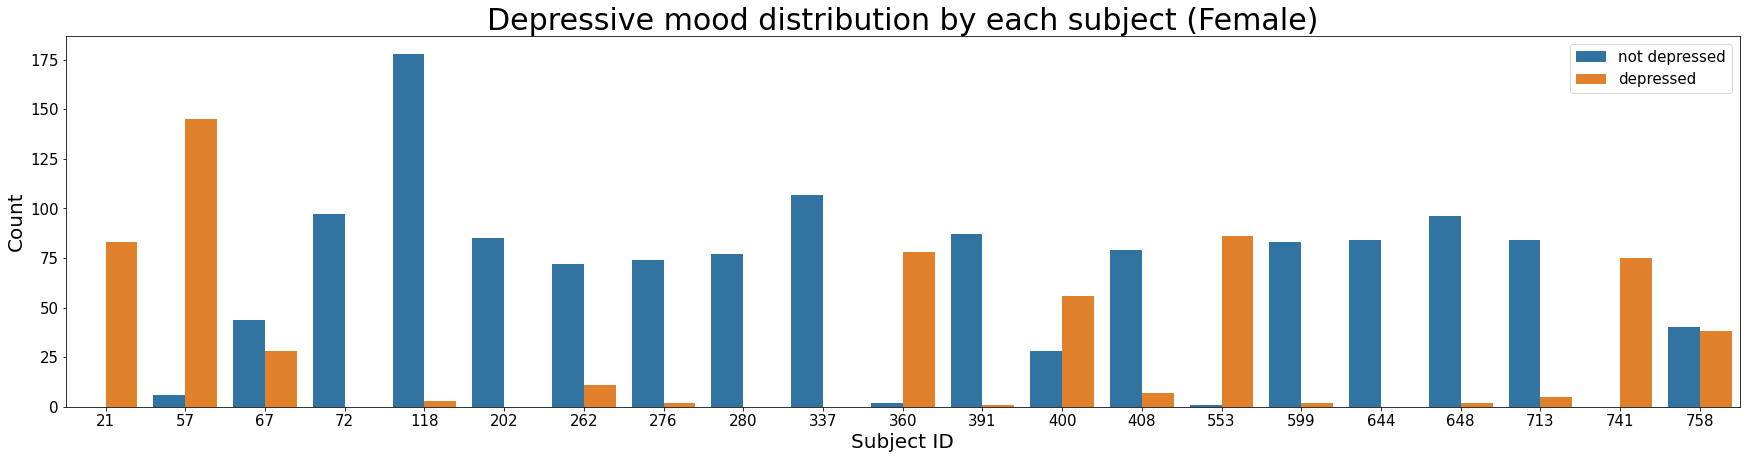

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 15))
ax = fig.add_axes([0,0,1,1])
plt.subplot(2, 1, 1)

plt.tick_params(labelsize = 15)
sns.countplot(x = 'pid', hue ='depressed', data = aos_ema.loc[female_pids].reset_index())
plt.title("Depressive mood distribution by each subject (Female)", fontsize = 30)
plt.xlabel("Subject ID", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.legend(labels=['not depressed', 'depressed'], fontsize = 15)
plt.show()

In [47]:
df_pids['age'] = 2022 - pd.to_datetime(df_pids['Unnamed: 5']).dt.year

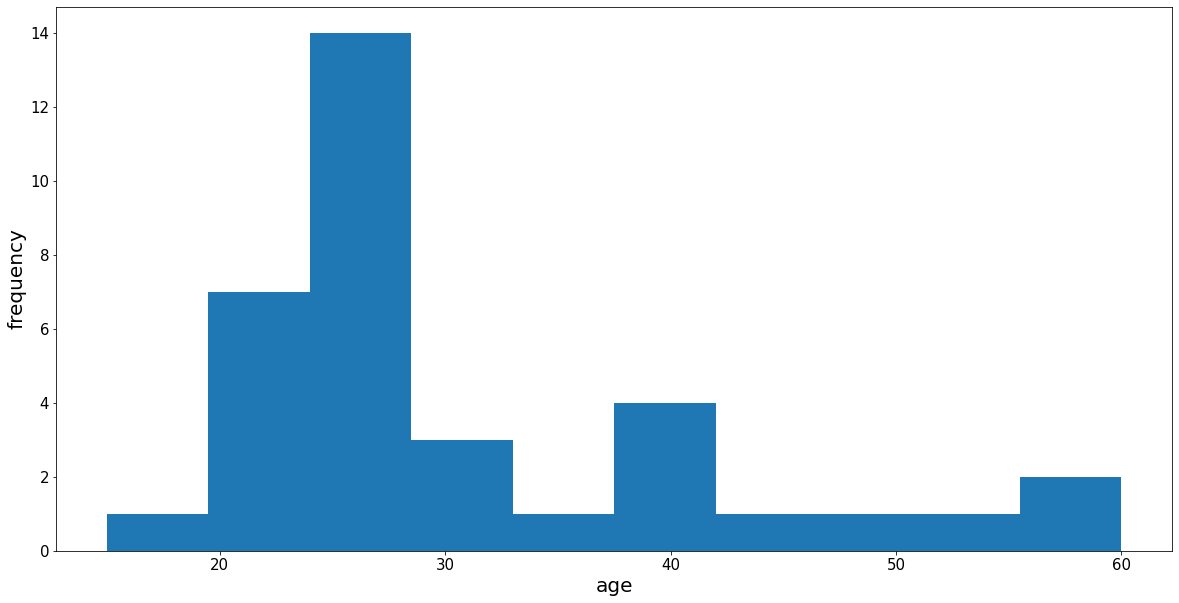

In [144]:
plt.figure(figsize=(20,10))
plt.tick_params(labelsize = 15)
plt.xlabel('age', fontsize = 20)
plt.ylabel('frequency', fontsize = 20)
plt.hist(df_pids['age'])
plt.show()

In [147]:
len(df_pids.loc[df_pids['age'] < 30])

23

# Data Augmentation

## PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px 
import numpy as np

feature_df = merged_data.drop('label', axis=1)

df_pca = StandardScaler().fit_transform(feature_df)
pca = PCA(n_components='mle', svd_solver='full')
principalComponents = pca.fit_transform(df_pca)
principalComponents.shape

In [149]:
variance = pca.explained_variance_ratio_
print(variance)
print('pca.n_components:', pca.n_components_)

depressed
pid timestamp                                     
14  2021-09-13 20:26:52.217999872+09:00        1.0
    2021-09-16 12:09:20.220999936+09:00        1.0
    2021-09-16 16:27:39.924999936+09:00        1.0
    2021-09-16 20:11:52.897999872+09:00        1.0
    2021-09-19 12:00:53.323000064+09:00        1.0
...                                            ...
797 2022-02-09 12:00:28.307000064+09:00        0.0
    2022-02-09 16:09:13.928999936+09:00        0.0
    2022-02-12 12:00:42.390000128+09:00        0.0
    2022-02-12 16:22:20.736999936+09:00        0.0
    2022-02-12 20:00:24.059000064+09:00        0.0

[3033 rows x 1 columns]

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
fig = px.line(data, x='Number of Features', y='Variance Explained', title = 'PCA Analysis', markers = True)

#fig.update_traces(mode='markers+lines')
fig.update_layout(width=700,
                  height=500,
                  plot_bgcolor='rgba(0,0,0, 0)',
                  xaxis={'tickformat':',d'})
fig.update_xaxes(dtick=1, showline=True, linecolor='black')
fig.update_yaxes(showline=True, linecolor='black')

fig.show()

In [ ]:
df = merged_data.copy()
df['principal component 1'] = principalComponents[:, 0]
df['principal component 2'] = principalComponents[:, 1]
df['principal component 3'] = principalComponents[:, 2]

# Plot a 2D scatter plot after dimension reduction
fig = px.scatter(df, x='principal component 1', y = 'principal component 2', size_max = 5, opacity=0.5, color = 'label'  )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0)             
                 )
fig.show()

In [ ]:
# PLot a 3D scatter plot after dimension reduction
fig = px.scatter_3d(df, x='principal component 1', y='principal component 2', z='principal component 3', size_max = 5, opacity=0.5, color = 'label')
fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Autoencoder

In [150]:
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np

ModuleNotFoundError: No module named 'keras'

In [ ]:
#reduce dimension in 2D
hidden_size = 3 
input_size = 4 

input_data = Input(shape=(input_size,))

encoded = Dense(hidden_size, activation='relu')(input_data) 

decoded = Dense(input_size, activation='sigmoid')(encoded) 

autoencoder = Model(input_data, decoded) 
encoder = Model(input_data, encoded)

encoded_input = Input(shape=(hidden_size,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

print(autoencoder.summary())

In [ ]:
# do min-max normlization
dataset = (dataset - dataset.min())/(dataset.max(0) - dataset.min()) 

dataset_length = len(dataset)
x_train = np.array(dataset[:int(dataset_length*0.9)]) # use 90% of the data as a train set
x_test = np.array(dataset[int(dataset_length*0.9):]) # use 10% of the data as a test set
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) 
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))) 

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
encoded_data = encoder.predict(dataset)
decoded_data = decoder.predict(encoded_data)
print(encoded_data.shape)

In [ ]:
a = encoded_data.reshape(3, 110489)
df = merged_data.copy()
df['comp_1'] = a[0]
df['comp_2'] = a[1]

fig = px.scatter(df, x='comp_1', y='comp_2', color = 'label', opacity=0.4)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
df['comp_1'] = a[0]
df['comp_2'] = a[1]
df['comp_3'] = a[2]

fig = px.scatter_3d(df, x='comp_1', y='comp_2', z='comp_3', color = 'label', opacity=0.4)
fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()